In [1]:
import torch
from torch.utils.data import DataLoader

from torchvision.transforms import v2

import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm.notebook import tqdm

%load_ext autoreload
%autoreload 2
from utils.helpers import  plot_some_images ,read_images
from utils.Preprocessing import WhiteTopHat , CLAHE , normalize_xca
from utils.dataset import  UnetDataset
from models.nnunet import nnUnet
from utils.losses import UnetLoss
from utils.recorder import HistoryRecorder
from utils.logger import save_full_report
from trainer import trainer

# Training

In [2]:
args = {
    "base_path" : "../arcade/nnUnet_dataset/syntax",
    "in_c" : 1,
    "base_channel" :32,
    "image_shape" : (512,512),
    "class_count" : 26 ,
    "attention" : True,
    "batch_size" : 10,
    "num_workers" : 10,
    "device" : "cuda" if torch.cuda.is_available() else "cpu",
    "lr" : 0.001,
    "momentum" : 0.9,
    "epcohs":100,
    "f_int_scale" : 2,
    "full_report_cycle" : 10,
    "max_channels":512,
    "input_channels":1,
    "loss_type":"tversky loss",
    "alpha":0.75,
    "beta":0.25,
    "gamma":1.33,
    "output_base_path" : "./outputs",
    "name" : "Attention7-teversky"
}
class_map = {
    0: '1',1: '2', 2: '3',3: '4',
    4: '5',5: '6',6: '7',7: '8',
    8: '9',9: '9a',10: '10',11: '10a',
    12: '11',13: '12',14: '12a',15: '13',
    16: '14',17: '14a',18: '15',19: '16',
    20: '16a',21: '16b',22: '16c',
    23: '12b',24: '14b'
}
losses_keys = ["total loss","CE loss",args["loss_type"]]

In [3]:
train_transforms = A.Compose([
    A.GaussianBlur(
        sigma_limit=[0.1,0.5],
        p=0.5
    ),
    A.RandomBrightnessContrast(
        brightness_limit=0.1,
        contrast_limit=0.15,
        brightness_by_max=True,
        p=0.3
    ),
    A.RandomGamma(
        gamma_limit=(90, 120), 
        p=0.3
    ),
    A.Rotate(limit=15, p=0.3 , fill_mask = 25),
    A.HorizontalFlip(p=0.3),
    A.VerticalFlip(p=0.3),
    A.Lambda(image=normalize_xca),
    ToTensorV2()
])
test_transforms = A.Compose([
    A.Lambda(image=normalize_xca),
    ToTensorV2()
])
# train_preprocess = v2.Compose([
#     WhiteTopHat(kernel_size=(50,50)),
#     CLAHE()
    
# ])
train_preprocess = None

In [4]:

train_images = read_images(base_path = args["base_path"],preprocessor = train_preprocess,part = "train")
valid_images = read_images(base_path = args["base_path"],preprocessor = train_preprocess,part = "val")

train_ds = UnetDataset(transform = train_transforms,data = train_images)
valid_ds = UnetDataset(transform = test_transforms,data = valid_images)

train_loader = DataLoader(
    train_ds,
    batch_size = args["batch_size"] ,
    num_workers = args["num_workers"] ,
    pin_memory=True,
    shuffle=True
)
valid_loader = DataLoader(
    valid_ds,
    batch_size = args["batch_size"] ,
    num_workers = args["num_workers"] ,
    pin_memory=True,
    shuffle=False,
)

NOTE : preprocessor is not defined . no preprocessing will be used !


  0%|          | 0/1000 [00:00<?, ?it/s]

NOTE : preprocessor is not defined . no preprocessing will be used !


  0%|          | 0/200 [00:00<?, ?it/s]

In [5]:
# plot_some_images(train_images, train_transforms, image_counts=36, fig_shape=(6,6), base_transforms=test_transforms)

In [6]:
model = nnUnet(args).to(args["device"])
loss_fn = UnetLoss(args)
optimizer = torch.optim.Adam(model.parameters(), lr=args["lr"])
recorder = HistoryRecorder(losses_keys=losses_keys,class_maps =class_map)
trainer(args,recorder,model,optimizer,loss_fn,train_loader,valid_loader)

number of layers : 7
encoder settings :  [32, 64, 128, 256, 512, 512, 512]
bottle-neck settings :  1024
decoder settings :  [1024, 1024, 512, 256, 128, 64]
head settings :  26
loss is set to tversky


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (0)
total loss : 2.8461706042289734 - CE loss : 1.8589327412843704 - tversky loss : 0.9872378611564636

train avg metrics for epoch 0 :
avg dice : 0.006428917823520511 - avg precision : 0.010092113824284751 - avg recall : 0.01701759058909374
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (0)
total loss : 1.7968923151493073 - CE loss : 0.8128902643918992 - tversky loss : 0.9840020656585693

valid avg metrics for epoch 0 :
avg dice : 0.011266903249313696 - avg precision : 0.024062237739562987 - avg recall : 0.013235782745905453
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (1)
total loss : 1.3948883664608003 - CE loss : 0.44072273433208464 - tversky loss : 0.9541656357049942

train avg metrics for epoch 1 :
avg dice : 0.013746297415093912 - avg precision : 0.02523706793785095 - avg recall : 0.020712610066475463
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (1)
total loss : 1.1996076226234436 - CE loss : 0.26722416207194327 - tversky loss : 0.9323834598064422

valid avg metrics for epoch 1 :
avg dice : 0.013210497803928058 - avg precision : 0.028994099199771882 - avg recall : 0.02563266407814808
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (2)
total loss : 1.0795813250541686 - CE loss : 0.20777536556124687 - tversky loss : 0.8718059539794922

train avg metrics for epoch 2 :
avg dice : 0.04120526456318332 - avg precision : 0.04605317503213882 - avg recall : 0.04791400509770028
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (2)
total loss : 1.0189110100269319 - CE loss : 0.18458777144551278 - tversky loss : 0.834323251247406

valid avg metrics for epoch 2 :
avg dice : 0.057718651462747524 - avg precision : 0.06526115119457244 - avg recall : 0.0693348731007427
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (3)
total loss : 0.9195091998577118 - CE loss : 0.16414433747529983 - tversky loss : 0.755364859700203

train avg metrics for epoch 3 :
avg dice : 0.08270287036939646 - avg precision : 0.09499630838632583 - avg recall : 0.08710881549865007
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (3)
total loss : 0.8728009790182114 - CE loss : 0.167661339789629 - tversky loss : 0.7051396310329437

valid avg metrics for epoch 3 :
avg dice : 0.12646563082971926 - avg precision : 0.13624572783708572 - avg recall : 0.1261151061952114
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (4)
total loss : 0.7980879408121109 - CE loss : 0.15002275206148624 - tversky loss : 0.6480651867389678

train avg metrics for epoch 4 :
avg dice : 0.12616766035600657 - avg precision : 0.12679310083389284 - avg recall : 0.1294836761057377
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (4)
total loss : 0.8287158757448196 - CE loss : 0.16321532428264618 - tversky loss : 0.665500545501709

valid avg metrics for epoch 4 :
avg dice : 0.1262215315554373 - avg precision : 0.15969247594475747 - avg recall : 0.12818503189831973
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (5)
total loss : 0.7153905463218689 - CE loss : 0.13981724746525287 - tversky loss : 0.5755732971429824

train avg metrics for epoch 5 :
avg dice : 0.15660824168517262 - avg precision : 0.16032633125782014 - avg recall : 0.1615428140759468
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (5)
total loss : 0.7649817258119583 - CE loss : 0.158212810754776 - tversky loss : 0.60676891207695

valid avg metrics for epoch 5 :
avg dice : 0.15983630394134526 - avg precision : 0.1877161854505539 - avg recall : 0.16131506210018415
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (6)
total loss : 0.6591183391213417 - CE loss : 0.13320055961608887 - tversky loss : 0.5259177795052529

train avg metrics for epoch 6 :
avg dice : 0.17889568794635202 - avg precision : 0.1825451286882162 - avg recall : 0.18365540662991406
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (6)
total loss : 0.680860635638237 - CE loss : 0.14088107645511627 - tversky loss : 0.5399795636534691

valid avg metrics for epoch 6 :
avg dice : 0.1960223235379889 - avg precision : 0.21561503350734712 - avg recall : 0.19103572744876146
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (7)
total loss : 0.6113331940770149 - CE loss : 0.12628153204917908 - tversky loss : 0.4850516626238823

train avg metrics for epoch 7 :
avg dice : 0.19899370705985184 - avg precision : 0.20372898168861867 - avg recall : 0.20347036667400972
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (7)
total loss : 0.6962735503911972 - CE loss : 0.1470556803047657 - tversky loss : 0.5492178618907928

valid avg metrics for epoch 7 :
avg dice : 0.1941187849155612 - avg precision : 0.2062285253405571 - avg recall : 0.19458343521720964
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (8)
total loss : 0.5999637538194657 - CE loss : 0.12511327363550662 - tversky loss : 0.4748504817485809

train avg metrics for epoch 8 :
avg dice : 0.20603660291569695 - avg precision : 0.21050938919186593 - avg recall : 0.21041201518848537
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (8)
total loss : 0.6745981782674789 - CE loss : 0.1445599678903818 - tversky loss : 0.5300382107496262

valid avg metrics for epoch 8 :
avg dice : 0.20327211921255678 - avg precision : 0.2268971860408783 - avg recall : 0.1966815869718266
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (9)
total loss : 0.5895690575242043 - CE loss : 0.12447019696235656 - tversky loss : 0.4650988593697548

train avg metrics for epoch 9 :
avg dice : 0.21113009842970548 - avg precision : 0.2241205593943596 - avg recall : 0.2158351597022556
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (9)
total loss : 0.6146097540855407 - CE loss : 0.13174287043511868 - tversky loss : 0.48286688327789307

valid avg metrics for epoch 9 :
avg dice : 0.22998372369538544 - avg precision : 0.2534336368739605 - avg recall : 0.2214990965242032
1 => dice : 0.66404789686203 p : 0.8076285123825073 , r : 0.5638129115104675
2 => dice : 0.6142378449440002 p : 0.676259458065033 , r : 0.5626368522644043
3 => dice : 0.5942996144294739 p : 0.6117987036705017 , r : 0.5777738094329834
4 => dice : 0.355123907327652 p : 0.3828409016132355 , r : 0.33114930987358093
5 => dice : 0.6475649476051331 p : 0.728538453578949 , r : 0.5827905535697937
6 => dice : 0.5294440388679504 p : 0.

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (10)
total loss : 0.5557721063494683 - CE loss : 0.11925124295055867 - tversky loss : 0.4365208637714386

train avg metrics for epoch 10 :
avg dice : 0.2267950450437512 - avg precision : 0.23892464969307184 - avg recall : 0.2294626663107192
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (10)
total loss : 0.615037202835083 - CE loss : 0.13372452035546303 - tversky loss : 0.48131268173456193

valid avg metrics for epoch 10 :
avg dice : 0.23373907024774143 - avg precision : 0.27234278075397017 - avg recall : 0.22601987837231718
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (11)
total loss : 0.5295322287082672 - CE loss : 0.11514725901186466 - tversky loss : 0.4143849715590477

train avg metrics for epoch 11 :
avg dice : 0.2425513035223251 - avg precision : 0.25641178764402867 - avg recall : 0.24274086807359707
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (11)
total loss : 0.6286228686571121 - CE loss : 0.13542999215424062 - tversky loss : 0.49319287538528445

valid avg metrics for epoch 11 :
avg dice : 0.2273029455346577 - avg precision : 0.25233832344412804 - avg recall : 0.22415348152477235
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (12)
total loss : 0.5408341699838638 - CE loss : 0.11787714213132858 - tversky loss : 0.4229570266604423

train avg metrics for epoch 12 :
avg dice : 0.23879179789406368 - avg precision : 0.2560703695565462 - avg recall : 0.2400159270731092
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (12)
total loss : 0.5895644545555114 - CE loss : 0.13155732117593288 - tversky loss : 0.45800713151693345

valid avg metrics for epoch 12 :
avg dice : 0.24788111909082727 - avg precision : 0.2824550452828407 - avg recall : 0.2332976946630515
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (13)
total loss : 0.5322249010205269 - CE loss : 0.11696878924965859 - tversky loss : 0.41525611221790315

train avg metrics for epoch 13 :
avg dice : 0.24404386039894443 - avg precision : 0.2538667542859912 - avg recall : 0.24381750746644684
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (13)
total loss : 0.5948044717311859 - CE loss : 0.13055916391313077 - tversky loss : 0.46424531042575834

valid avg metrics for epoch 13 :
avg dice : 0.2509895286577111 - avg precision : 0.27571204722858966 - avg recall : 0.24352529319781752
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (14)
total loss : 0.49469670206308364 - CE loss : 0.10928945139050483 - tversky loss : 0.3854072472453117

train avg metrics for epoch 14 :
avg dice : 0.26311374062597886 - avg precision : 0.27517457991838457 - avg recall : 0.26221832063631156
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (14)
total loss : 0.5737441495060921 - CE loss : 0.1295836389064789 - tversky loss : 0.44416051357984543

valid avg metrics for epoch 14 :
avg dice : 0.25929417898435714 - avg precision : 0.2864763422124088 - avg recall : 0.25029018193949015
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (15)
total loss : 0.49595042914152143 - CE loss : 0.11103536732494831 - tversky loss : 0.3849150612950325

train avg metrics for epoch 15 :
avg dice : 0.26185046489792474 - avg precision : 0.2726871544867754 - avg recall : 0.26066475238389103
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (15)
total loss : 0.5701625317335128 - CE loss : 0.12443608045578003 - tversky loss : 0.44572644531726835

valid avg metrics for epoch 15 :
avg dice : 0.26103245280716475 - avg precision : 0.29326617643237113 - avg recall : 0.2535981143359095
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (16)
total loss : 0.486909254193306 - CE loss : 0.10978489771485328 - tversky loss : 0.3771243545413017

train avg metrics for epoch 16 :
avg dice : 0.26982561923605525 - avg precision : 0.2820901194214821 - avg recall : 0.2672811351157725
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (16)
total loss : 0.6064152091741561 - CE loss : 0.13511827476322652 - tversky loss : 0.47129693180322646

valid avg metrics for epoch 16 :
avg dice : 0.24430273480736284 - avg precision : 0.2681434899568558 - avg recall : 0.24263198602944613
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (17)
total loss : 0.4912039318680763 - CE loss : 0.1103956800699234 - tversky loss : 0.38080825239419935

train avg metrics for epoch 17 :
avg dice : 0.2675644548986586 - avg precision : 0.281313593685627 - avg recall : 0.26575160373002293
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (17)
total loss : 0.5789641737937927 - CE loss : 0.12709777876734735 - tversky loss : 0.4518663987517357

valid avg metrics for epoch 17 :
avg dice : 0.25615165512798915 - avg precision : 0.28854394420981405 - avg recall : 0.23895336187291832
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (18)
total loss : 0.478023017346859 - CE loss : 0.10848607055842877 - tversky loss : 0.36953694850206376

train avg metrics for epoch 18 :
avg dice : 0.2746599511728079 - avg precision : 0.29127850957214835 - avg recall : 0.2723624400224071
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (18)
total loss : 0.5686807498335839 - CE loss : 0.12608592510223388 - tversky loss : 0.4425948172807693

valid avg metrics for epoch 18 :
avg dice : 0.2660796077441006 - avg precision : 0.31353423483669757 - avg recall : 0.2559059929047362
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (19)
total loss : 0.4646550962328911 - CE loss : 0.10554886944591998 - tversky loss : 0.35910622611641885

train avg metrics for epoch 19 :
avg dice : 0.2847954733371177 - avg precision : 0.3060826808586717 - avg recall : 0.2823062005965039
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (19)
total loss : 0.5510261297225952 - CE loss : 0.12413486503064633 - tversky loss : 0.42689125835895536

valid avg metrics for epoch 19 :
avg dice : 0.2761002069713977 - avg precision : 0.30607145771384237 - avg recall : 0.26596594337373974
1 => dice : 0.7118380665779114 p : 0.7415100336074829 , r : 0.6844494938850403
2 => dice : 0.6385465264320374 p : 0.6755759716033936 , r : 0.6053654551506042
3 => dice : 0.6188955307006836 p : 0.6321810483932495 , r : 0.6061568856239319
4 => dice : 0.4624660909175873 p : 0.4843595623970032 , r : 0.44246622920036316
5 => dice : 0.6505118012428284 p : 0.7658278942108154 , r : 0.565378725528717
6 => dice : 0.56526607275009

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (20)
total loss : 0.47078600496053696 - CE loss : 0.10772528097033501 - tversky loss : 0.3630607223510742

train avg metrics for epoch 20 :
avg dice : 0.28480607036832567 - avg precision : 0.3065672081708908 - avg recall : 0.280855920762624
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (20)
total loss : 0.5575760111212731 - CE loss : 0.12268158346414566 - tversky loss : 0.4348944306373596

valid avg metrics for epoch 20 :
avg dice : 0.27946964532159835 - avg precision : 0.3135610668361187 - avg recall : 0.2661527828127146
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (21)
total loss : 0.45554278790950775 - CE loss : 0.10389018543064595 - tversky loss : 0.3516526015102863

train avg metrics for epoch 21 :
avg dice : 0.2957450398617618 - avg precision : 0.3177009724080563 - avg recall : 0.2909003743052017
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (21)
total loss : 0.5495328068733215 - CE loss : 0.12547507844865322 - tversky loss : 0.42405773252248763

valid avg metrics for epoch 21 :
avg dice : 0.27877634145284946 - avg precision : 0.31539351949468253 - avg recall : 0.2638003195245983
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (22)
total loss : 0.4464894723892212 - CE loss : 0.10288606651127338 - tversky loss : 0.34360340565443037

train avg metrics for epoch 22 :
avg dice : 0.2977413437892087 - avg precision : 0.3132212473452091 - avg recall : 0.2944936171360314
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (22)
total loss : 0.5460816815495491 - CE loss : 0.1203719899058342 - tversky loss : 0.4257096886634827

valid avg metrics for epoch 22 :
avg dice : 0.28261583901961673 - avg precision : 0.3242873078584671 - avg recall : 0.2687845661863685
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (23)
total loss : 0.43393822103738783 - CE loss : 0.10080924108624459 - tversky loss : 0.33312897995114327

train avg metrics for epoch 23 :
avg dice : 0.30617471607209495 - avg precision : 0.3249014738947153 - avg recall : 0.302934494948131
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (23)
total loss : 0.537989541888237 - CE loss : 0.1262481540441513 - tversky loss : 0.4117413878440857

valid avg metrics for epoch 23 :
avg dice : 0.2907485249640655 - avg precision : 0.34221558332443236 - avg recall : 0.27153707491233947
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (24)
total loss : 0.4346738764643669 - CE loss : 0.10133451551198959 - tversky loss : 0.33333936125040053

train avg metrics for epoch 24 :
avg dice : 0.30803351486258523 - avg precision : 0.3246072778105736 - avg recall : 0.303590321969823
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (24)
total loss : 0.5228614807128906 - CE loss : 0.11922508403658867 - tversky loss : 0.40363639295101167

valid avg metrics for epoch 24 :
avg dice : 0.30409813702124466 - avg precision : 0.32447690367698667 - avg recall : 0.29771657660603523
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (25)
total loss : 0.42157932341098786 - CE loss : 0.0991172395646572 - tversky loss : 0.3224620819091797

train avg metrics for epoch 25 :
avg dice : 0.3193925022110876 - avg precision : 0.3332503859698772 - avg recall : 0.3146441892566509
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (25)
total loss : 0.5193963885307312 - CE loss : 0.11740993224084377 - tversky loss : 0.4019864544272423

valid avg metrics for epoch 25 :
avg dice : 0.2970479114169192 - avg precision : 0.3258294127881527 - avg recall : 0.28417390906251966
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (26)
total loss : 0.41150369614362714 - CE loss : 0.09697644121944904 - tversky loss : 0.31452725514769553

train avg metrics for epoch 26 :
avg dice : 0.3290797429302977 - avg precision : 0.3498324041068554 - avg recall : 0.3225615090772044
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (26)
total loss : 0.5116692438721657 - CE loss : 0.11866206265985965 - tversky loss : 0.3930071771144867

valid avg metrics for epoch 26 :
avg dice : 0.31231134161371105 - avg precision : 0.342463515996933 - avg recall : 0.2955770019441843
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (27)
total loss : 0.4157329699397087 - CE loss : 0.09751948248595 - tversky loss : 0.31821348786354064

train avg metrics for epoch 27 :
avg dice : 0.3277319279555734 - avg precision : 0.35100071450695397 - avg recall : 0.32223411846345695
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (27)
total loss : 0.5291862443089486 - CE loss : 0.11870009787380695 - tversky loss : 0.41048614382743837

valid avg metrics for epoch 27 :
avg dice : 0.29713826671269944 - avg precision : 0.36180982261896133 - avg recall : 0.2761625787243247
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (28)
total loss : 0.39939982518553735 - CE loss : 0.09435761377215385 - tversky loss : 0.30504221200942994

train avg metrics for epoch 28 :
avg dice : 0.3408065702985434 - avg precision : 0.3716100746393204 - avg recall : 0.33330249096266923
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (28)
total loss : 0.5059826582670212 - CE loss : 0.11513140238821507 - tversky loss : 0.39085126370191575

valid avg metrics for epoch 28 :
avg dice : 0.31385322351955514 - avg precision : 0.3590221015363932 - avg recall : 0.2893706267839298
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (29)
total loss : 0.4066018235683441 - CE loss : 0.09614999242126941 - tversky loss : 0.3104518307745457

train avg metrics for epoch 29 :
avg dice : 0.33605592988470306 - avg precision : 0.36526640728116033 - avg recall : 0.3295085331052542
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (29)
total loss : 0.5320188298821449 - CE loss : 0.1204445168375969 - tversky loss : 0.41157431304454806

valid avg metrics for epoch 29 :
avg dice : 0.310072933733643 - avg precision : 0.3238821205496788 - avg recall : 0.30956399291753767
1 => dice : 0.7162799835205078 p : 0.7191342115402222 , r : 0.7134482860565186
2 => dice : 0.6708345413208008 p : 0.6757301092147827 , r : 0.6660093665122986
3 => dice : 0.6336799263954163 p : 0.7154645323753357 , r : 0.5686748623847961
4 => dice : 0.4841834306716919 p : 0.4242510199546814 , r : 0.5638343095779419
5 => dice : 0.6205524802207947 p : 0.7836424112319946 , r : 0.5136522650718689
6 => dice : 0.5482155680656433

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (30)
total loss : 0.4166963994503021 - CE loss : 0.09882325135171413 - tversky loss : 0.3178731486201286

train avg metrics for epoch 30 :
avg dice : 0.3327902897823913 - avg precision : 0.35020840883255006 - avg recall : 0.3260506438836455
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (30)
total loss : 0.5070062786340713 - CE loss : 0.11292064450681209 - tversky loss : 0.3940856337547302

valid avg metrics for epoch 30 :
avg dice : 0.3154314496183607 - avg precision : 0.37144853949546813 - avg recall : 0.297983442209661
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (31)
total loss : 0.4004671385884285 - CE loss : 0.09453326925635337 - tversky loss : 0.30593386948108675

train avg metrics for epoch 31 :
avg dice : 0.339268380704259 - avg precision : 0.3583830749243498 - avg recall : 0.33305435431888325
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (31)
total loss : 0.49994784891605376 - CE loss : 0.11368844844400883 - tversky loss : 0.38625939935445786

valid avg metrics for epoch 31 :
avg dice : 0.3219667707292199 - avg precision : 0.3812304836511612 - avg recall : 0.30579736035782845
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (32)
total loss : 0.3803197646141052 - CE loss : 0.0911094906181097 - tversky loss : 0.28921027436852453

train avg metrics for epoch 32 :
avg dice : 0.35509252445811174 - avg precision : 0.3792251289635897 - avg recall : 0.3490422531799413
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (32)
total loss : 0.4903839245438576 - CE loss : 0.11106110587716103 - tversky loss : 0.3793228164315224

valid avg metrics for epoch 32 :
avg dice : 0.3323805670179319 - avg precision : 0.3805379528552294 - avg recall : 0.3232101538340794
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (33)
total loss : 0.3724324090778828 - CE loss : 0.08962152268737554 - tversky loss : 0.28281088411808014

train avg metrics for epoch 33 :
avg dice : 0.36091603847257714 - avg precision : 0.3852362057566643 - avg recall : 0.3530347071681172
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (33)
total loss : 0.4862561747431755 - CE loss : 0.11088224612176419 - tversky loss : 0.3753739304840565

valid avg metrics for epoch 33 :
avg dice : 0.33814555499714233 - avg precision : 0.37447001844644545 - avg recall : 0.32761697949841617
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (34)
total loss : 0.3699609291553497 - CE loss : 0.08947816848754883 - tversky loss : 0.28048275902867315

train avg metrics for epoch 34 :
avg dice : 0.36627401165701373 - avg precision : 0.39491951406002046 - avg recall : 0.3586247584503144
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (34)
total loss : 0.48552258759737016 - CE loss : 0.11015407629311084 - tversky loss : 0.3753685101866722

valid avg metrics for epoch 34 :
avg dice : 0.340348017402146 - avg precision : 0.38706050187349317 - avg recall : 0.3223321898840368
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (35)
total loss : 0.3660387849807739 - CE loss : 0.08880640044808388 - tversky loss : 0.27723238602280614

train avg metrics for epoch 35 :
avg dice : 0.37294473126567823 - avg precision : 0.39993221551179886 - avg recall : 0.3634957022219896
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (35)
total loss : 0.48219422399997713 - CE loss : 0.11020923256874085 - tversky loss : 0.3719849944114685

valid avg metrics for epoch 35 :
avg dice : 0.3447375360691114 - avg precision : 0.3694837811589241 - avg recall : 0.3424651863798499
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (36)
total loss : 0.3956871518492699 - CE loss : 0.09546555232256651 - tversky loss : 0.3002215997874737

train avg metrics for epoch 36 :
avg dice : 0.3562438487451516 - avg precision : 0.37922681093215943 - avg recall : 0.3475750567112118
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (36)
total loss : 0.47416824400424956 - CE loss : 0.10780323594808579 - tversky loss : 0.36636500880122186

valid avg metrics for epoch 36 :
avg dice : 0.341379033974492 - avg precision : 0.3821700456365943 - avg recall : 0.33208686412195676
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (37)
total loss : 0.37027806520462037 - CE loss : 0.09003151573240757 - tversky loss : 0.28024654850363734

train avg metrics for epoch 37 :
avg dice : 0.3702303550768636 - avg precision : 0.3975968489050865 - avg recall : 0.3622169705480337
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (37)
total loss : 0.47654459774494173 - CE loss : 0.10866013281047344 - tversky loss : 0.3678844705224037

valid avg metrics for epoch 37 :
avg dice : 0.33755654085440157 - avg precision : 0.39518011048436164 - avg recall : 0.31207353588193654
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (38)
total loss : 0.36116935789585114 - CE loss : 0.08729797728359699 - tversky loss : 0.27387138158082963

train avg metrics for epoch 38 :
avg dice : 0.3808787044141434 - avg precision : 0.39866100817918776 - avg recall : 0.37225527852773665
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (38)
total loss : 0.4782379999756813 - CE loss : 0.11096883453428745 - tversky loss : 0.3672691635787487

valid avg metrics for epoch 38 :
avg dice : 0.3421997959540351 - avg precision : 0.3873424039781094 - avg recall : 0.3235603736154735
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (39)
total loss : 0.3623797382414341 - CE loss : 0.08841288879513741 - tversky loss : 0.27396684989333153

train avg metrics for epoch 39 :
avg dice : 0.38102576471902355 - avg precision : 0.40160914599895475 - avg recall : 0.37215234130620956
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (39)
total loss : 0.5318671554327011 - CE loss : 0.12507724054157734 - tversky loss : 0.4067899137735367

valid avg metrics for epoch 39 :
avg dice : 0.30098705146472293 - avg precision : 0.3788162302970886 - avg recall : 0.2723041184991598
1 => dice : 0.6942563652992249 p : 0.7524487376213074 , r : 0.6444187164306641
2 => dice : 0.6439447999000549 p : 0.6815435290336609 , r : 0.6102775931358337
3 => dice : 0.5873194336891174 p : 0.594333291053772 , r : 0.5804691314697266
4 => dice : 0.5017993450164795 p : 0.5398411750793457 , r : 0.46876609325408936
5 => dice : 0.6142500042915344 p : 0.7061523199081421 , r : 0.5435142517089844
6 => dice : 0.5745231509208

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (40)
total loss : 0.35878091275691987 - CE loss : 0.08766402598470449 - tversky loss : 0.27111688658595084

train avg metrics for epoch 40 :
avg dice : 0.3837359558049582 - avg precision : 0.4044047585129738 - avg recall : 0.3743454703688622
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (40)
total loss : 0.48303302228450773 - CE loss : 0.11342675276100636 - tversky loss : 0.3696062691509724

valid avg metrics for epoch 40 :
avg dice : 0.3410007457622452 - avg precision : 0.3989508654177189 - avg recall : 0.3214219398424029
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (41)
total loss : 0.3437624958157539 - CE loss : 0.0849581180140376 - tversky loss : 0.25880437806248663

train avg metrics for epoch 41 :
avg dice : 0.3923175580803297 - avg precision : 0.4122090178728104 - avg recall : 0.3831756780296564
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (41)
total loss : 0.47019110172986983 - CE loss : 0.1121951911598444 - tversky loss : 0.35799591094255445

valid avg metrics for epoch 41 :
avg dice : 0.35232902623723583 - avg precision : 0.3880168681591749 - avg recall : 0.3397539223358035
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (42)
total loss : 0.3486556324362755 - CE loss : 0.08560691632330418 - tversky loss : 0.26304871633648874

train avg metrics for epoch 42 :
avg dice : 0.39460256516970615 - avg precision : 0.4108351948857307 - avg recall : 0.38673002138733864
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (42)
total loss : 0.4628222107887268 - CE loss : 0.10728858895599842 - tversky loss : 0.35553361997008326

valid avg metrics for epoch 42 :
avg dice : 0.3471276458353861 - avg precision : 0.3931455152481794 - avg recall : 0.3246681360900402
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (43)
total loss : 0.33606101661920545 - CE loss : 0.08352621600031852 - tversky loss : 0.252534801363945

train avg metrics for epoch 43 :
avg dice : 0.40328848406709655 - avg precision : 0.42141602843999865 - avg recall : 0.3942633894085884
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (43)
total loss : 0.44973033517599104 - CE loss : 0.10284737572073936 - tversky loss : 0.3468829579651356

valid avg metrics for epoch 43 :
avg dice : 0.363985986281292 - avg precision : 0.3999350705742836 - avg recall : 0.3519756906852126
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (44)
total loss : 0.35294073283672334 - CE loss : 0.08745094414800406 - tversky loss : 0.26548978939652446

train avg metrics for epoch 44 :
avg dice : 0.3871907806400202 - avg precision : 0.40489649057388305 - avg recall : 0.3788757087290287
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (44)
total loss : 0.4664516106247902 - CE loss : 0.10728726796805858 - tversky loss : 0.3591643422842026

valid avg metrics for epoch 44 :
avg dice : 0.34678859760995345 - avg precision : 0.3867849321849644 - avg recall : 0.3328231856552884
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (45)
total loss : 0.34809029623866083 - CE loss : 0.08626974944025279 - tversky loss : 0.2618205474317074

train avg metrics for epoch 45 :
avg dice : 0.3955557678271077 - avg precision : 0.4109334671497345 - avg recall : 0.3884743346273899
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (45)
total loss : 0.4634066462516785 - CE loss : 0.10611258521676063 - tversky loss : 0.35729406103491784

valid avg metrics for epoch 45 :
avg dice : 0.354568396657811 - avg precision : 0.4004667502641678 - avg recall : 0.3353577249497175
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (46)
total loss : 0.32938727363944054 - CE loss : 0.08253023441880941 - tversky loss : 0.24685703799128533

train avg metrics for epoch 46 :
avg dice : 0.40432238534130077 - avg precision : 0.4204262310266495 - avg recall : 0.39643752366304397
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (46)
total loss : 0.4670442283153534 - CE loss : 0.11139545887708664 - tversky loss : 0.3556487739086151

valid avg metrics for epoch 46 :
avg dice : 0.35409464493404463 - avg precision : 0.3843184472620487 - avg recall : 0.34146591382101177
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (47)
total loss : 0.3277559393644333 - CE loss : 0.08248611636459828 - tversky loss : 0.2452698230743408

train avg metrics for epoch 47 :
avg dice : 0.40959754914082436 - avg precision : 0.4253106316924095 - avg recall : 0.4022575752437115
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (47)
total loss : 0.4462008461356163 - CE loss : 0.10603235848248005 - tversky loss : 0.3401684872806072

valid avg metrics for epoch 47 :
avg dice : 0.37208836689601976 - avg precision : 0.40153922617435456 - avg recall : 0.3687858539819717
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (48)
total loss : 0.3191394563019276 - CE loss : 0.08108094967901706 - tversky loss : 0.23805850505828857

train avg metrics for epoch 48 :
avg dice : 0.41914238184727654 - avg precision : 0.43165499836206433 - avg recall : 0.4147694317996502
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (48)
total loss : 0.44681223928928376 - CE loss : 0.10519946925342083 - tversky loss : 0.34161276966333387

valid avg metrics for epoch 48 :
avg dice : 0.3663686097414358 - avg precision : 0.42037142768502234 - avg recall : 0.3356996748968959
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (49)
total loss : 0.3131433993577957 - CE loss : 0.07990822512656451 - tversky loss : 0.23323517486453058

train avg metrics for epoch 49 :
avg dice : 0.42179978042878136 - avg precision : 0.43724833071231844 - avg recall : 0.41442732080817224
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (49)
total loss : 0.4360370248556137 - CE loss : 0.10154327750205994 - tversky loss : 0.33449375033378603

valid avg metrics for epoch 49 :
avg dice : 0.37566578485082225 - avg precision : 0.4178737296909094 - avg recall : 0.35010794810950757
1 => dice : 0.7814523577690125 p : 0.8514875173568726 , r : 0.7220624089241028
2 => dice : 0.7101576924324036 p : 0.7561931014060974 , r : 0.6694057583808899
3 => dice : 0.7053687572479248 p : 0.7127715349197388 , r : 0.6981181502342224
4 => dice : 0.5985005497932434 p : 0.6277015209197998 , r : 0.5718957781791687
5 => dice : 0.7081224322319031 p : 0.7915830016136169 , r : 0.6405826210975647
6 => dice : 0.64385581016

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (50)
total loss : 0.31444693937897683 - CE loss : 0.08006113674491644 - tversky loss : 0.23438580125570296

train avg metrics for epoch 50 :
avg dice : 0.4216353771094225 - avg precision : 0.43380443811416625 - avg recall : 0.416798397898674
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (50)
total loss : 0.4492991790175438 - CE loss : 0.10493334271013736 - tversky loss : 0.3443658374249935

valid avg metrics for epoch 50 :
avg dice : 0.3693701390178068 - avg precision : 0.40809528410434726 - avg recall : 0.35374307312071324
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (51)
total loss : 0.3133100599050522 - CE loss : 0.080080734975636 - tversky loss : 0.2332293239235878

train avg metrics for epoch 51 :
avg dice : 0.41963569477237683 - avg precision : 0.43460417062044143 - avg recall : 0.41302514627575876
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (51)
total loss : 0.45345439910888674 - CE loss : 0.10499570220708847 - tversky loss : 0.34845869466662405

valid avg metrics for epoch 51 :
avg dice : 0.3618128655106886 - avg precision : 0.4023446348309517 - avg recall : 0.34648071650415657
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (52)
total loss : 0.3140502341091633 - CE loss : 0.08043290242552757 - tversky loss : 0.23361733227968215

train avg metrics for epoch 52 :
avg dice : 0.42266346097029667 - avg precision : 0.43712217569351197 - avg recall : 0.4160751037299633
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (52)
total loss : 0.4281192526221275 - CE loss : 0.09992163181304932 - tversky loss : 0.3281976155936718

valid avg metrics for epoch 52 :
avg dice : 0.3781242704392536 - avg precision : 0.4180462025851011 - avg recall : 0.3596346486359835
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (53)
total loss : 0.3037207129597664 - CE loss : 0.07843592714518309 - tversky loss : 0.22528478547930716

train avg metrics for epoch 53 :
avg dice : 0.4291300576928995 - avg precision : 0.441079244017601 - avg recall : 0.4246449863910675
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (53)
total loss : 0.44550736248493195 - CE loss : 0.10476865023374557 - tversky loss : 0.3407387137413025

valid avg metrics for epoch 53 :
avg dice : 0.36713016182194785 - avg precision : 0.4124669873714447 - avg recall : 0.3465976729989052
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (54)
total loss : 0.3016197234392166 - CE loss : 0.07781802345067262 - tversky loss : 0.22380169942975045

train avg metrics for epoch 54 :
avg dice : 0.4322800406817332 - avg precision : 0.44482087820768357 - avg recall : 0.4272187192738056
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (54)
total loss : 0.44826670140028 - CE loss : 0.1075654026120901 - tversky loss : 0.34070129692554474

valid avg metrics for epoch 54 :
avg dice : 0.36078367874036865 - avg precision : 0.42324552819132805 - avg recall : 0.3349756364151835
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (55)
total loss : 0.30541208416223525 - CE loss : 0.0785831406712532 - tversky loss : 0.22682894438505172

train avg metrics for epoch 55 :
avg dice : 0.4326894974712275 - avg precision : 0.44633637726306913 - avg recall : 0.42564732521772386
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (55)
total loss : 0.4343107983469963 - CE loss : 0.1018700037151575 - tversky loss : 0.33244079500436785

valid avg metrics for epoch 55 :
avg dice : 0.37101283219886333 - avg precision : 0.42088508415967224 - avg recall : 0.3493449706537649
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (56)
total loss : 0.2973917780816555 - CE loss : 0.07689241282641887 - tversky loss : 0.2204993650317192

train avg metrics for epoch 56 :
avg dice : 0.43623932927884085 - avg precision : 0.44989212065935136 - avg recall : 0.4299525111913681
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (56)
total loss : 0.43077521920204165 - CE loss : 0.10165146216750146 - tversky loss : 0.3291237525641918

valid avg metrics for epoch 56 :
avg dice : 0.38009260118018223 - avg precision : 0.41267708361148836 - avg recall : 0.36490450367331506
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (57)
total loss : 0.2995408235490322 - CE loss : 0.07741613078862429 - tversky loss : 0.22212469428777695

train avg metrics for epoch 57 :
avg dice : 0.4383689302209781 - avg precision : 0.45118927747011184 - avg recall : 0.4325846841931343
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (57)
total loss : 0.43943450748920443 - CE loss : 0.10489955805242061 - tversky loss : 0.3345349483191967

valid avg metrics for epoch 57 :
avg dice : 0.3766347904504402 - avg precision : 0.42942042648792267 - avg recall : 0.3558249419182539
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (58)
total loss : 0.2992082466185093 - CE loss : 0.0776190933212638 - tversky loss : 0.2215891546010971

train avg metrics for epoch 58 :
avg dice : 0.4343594458702944 - avg precision : 0.44645808428525924 - avg recall : 0.4293932223320007
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (58)
total loss : 0.4551756978034973 - CE loss : 0.10938497371971607 - tversky loss : 0.34579072520136833

valid avg metrics for epoch 58 :
avg dice : 0.37647585406910017 - avg precision : 0.3996612611413002 - avg recall : 0.3653927534073591
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (59)
total loss : 0.3049776601791382 - CE loss : 0.07901798743754625 - tversky loss : 0.22595967307686807

train avg metrics for epoch 59 :
avg dice : 0.43423477768935187 - avg precision : 0.4449227461218834 - avg recall : 0.43109882265329363
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (59)
total loss : 0.4371411368250847 - CE loss : 0.10259802751243115 - tversky loss : 0.33454310745000837

valid avg metrics for epoch 59 :
avg dice : 0.3722117219866379 - avg precision : 0.4188320757448673 - avg recall : 0.35217018336057665
1 => dice : 0.7571640014648438 p : 0.8132777214050293 , r : 0.7082937955856323
2 => dice : 0.6970476508140564 p : 0.7658188939094543 , r : 0.6396101117134094
3 => dice : 0.7037125825881958 p : 0.6886541843414307 , r : 0.7194442749023438
4 => dice : 0.5603554248809814 p : 0.7292354106903076 , r : 0.4549872577190399
5 => dice : 0.6800702810287476 p : 0.8232551217079163 , r : 0.5793130993843079
6 => dice : 0.6561239361763

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (60)
total loss : 0.2899611821770668 - CE loss : 0.0764400253072381 - tversky loss : 0.21352115601301194

train avg metrics for epoch 60 :
avg dice : 0.44871900081671695 - avg precision : 0.459399197101593 - avg recall : 0.4455171698331833
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (60)
total loss : 0.43182518631219863 - CE loss : 0.10298127718269826 - tversky loss : 0.3288439065217972

valid avg metrics for epoch 60 :
avg dice : 0.3771822907031639 - avg precision : 0.42970370173454286 - avg recall : 0.35135016456246376
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (61)
total loss : 0.3181673637032509 - CE loss : 0.08174321632832289 - tversky loss : 0.23642414793372155

train avg metrics for epoch 61 :
avg dice : 0.4251613771919153 - avg precision : 0.43623307466506955 - avg recall : 0.4195853793621063
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (61)
total loss : 0.4416279703378677 - CE loss : 0.1054592054337263 - tversky loss : 0.3361687667667866

valid avg metrics for epoch 61 :
avg dice : 0.3748681557179554 - avg precision : 0.41783685132861137 - avg recall : 0.3550838087499142
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (62)
total loss : 0.2907241749763489 - CE loss : 0.07555161040276288 - tversky loss : 0.21517256423830985

train avg metrics for epoch 62 :
avg dice : 0.4485189247135065 - avg precision : 0.458078408241272 - avg recall : 0.4462158846855164
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (62)
total loss : 0.42551791965961455 - CE loss : 0.09968802742660046 - tversky loss : 0.32582989186048505

valid avg metrics for epoch 62 :
avg dice : 0.3870343670250042 - avg precision : 0.4406482048332691 - avg recall : 0.36156746961176395
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (63)
total loss : 0.2843647001683712 - CE loss : 0.07436930008232594 - tversky loss : 0.20999539971351625

train avg metrics for epoch 63 :
avg dice : 0.4517820587757967 - avg precision : 0.46383718550205233 - avg recall : 0.446815564930439
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (63)
total loss : 0.42990725189447404 - CE loss : 0.10397011376917362 - tversky loss : 0.3259371392428875

valid avg metrics for epoch 63 :
avg dice : 0.3783042705060108 - avg precision : 0.4444368628412485 - avg recall : 0.3428637036681175
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (64)
total loss : 0.2799674393236637 - CE loss : 0.07380097456276417 - tversky loss : 0.20616646438837052

train avg metrics for epoch 64 :
avg dice : 0.45586986124552736 - avg precision : 0.4663136178255081 - avg recall : 0.4518586814403534
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (64)
total loss : 0.4369149684906006 - CE loss : 0.10514823161065578 - tversky loss : 0.33176674097776415

valid avg metrics for epoch 64 :
avg dice : 0.37037724703560904 - avg precision : 0.43520144909620284 - avg recall : 0.33444415498524904
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (65)
total loss : 0.28319345623254777 - CE loss : 0.07454284023493528 - tversky loss : 0.20865061551332473

train avg metrics for epoch 65 :
avg dice : 0.4574617370966807 - avg precision : 0.4673997765779495 - avg recall : 0.4539727881550789
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (65)
total loss : 0.4169290319085121 - CE loss : 0.09941577985882759 - tversky loss : 0.31751325353980064

valid avg metrics for epoch 65 :
avg dice : 0.38984527183707196 - avg precision : 0.41831706067547203 - avg recall : 0.3732495069410652
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (66)
total loss : 0.2710556469857693 - CE loss : 0.0719521040469408 - tversky loss : 0.19910354532301425

train avg metrics for epoch 66 :
avg dice : 0.46420401275195106 - avg precision : 0.47327769696712496 - avg recall : 0.4622067070007324
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (66)
total loss : 0.4165813058614731 - CE loss : 0.09993383139371873 - tversky loss : 0.31664747670292853

valid avg metrics for epoch 66 :
avg dice : 0.38957479089509084 - avg precision : 0.43240543887019156 - avg recall : 0.36812381118536
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (67)
total loss : 0.27689611122012137 - CE loss : 0.07382538221776486 - tversky loss : 0.20307072803378104

train avg metrics for epoch 67 :
avg dice : 0.4560591715577982 - avg precision : 0.46700470477342604 - avg recall : 0.45229706168174744
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (67)
total loss : 0.44099209159612657 - CE loss : 0.10763225220143795 - tversky loss : 0.3333598390221596

valid avg metrics for epoch 67 :
avg dice : 0.37661300420771676 - avg precision : 0.4350970160961151 - avg recall : 0.3451290075480938
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (68)
total loss : 0.2952362045645714 - CE loss : 0.0773400827869773 - tversky loss : 0.21789612054824828

train avg metrics for epoch 68 :
avg dice : 0.4476056933406733 - avg precision : 0.4559386897087097 - avg recall : 0.44686822563409806
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (68)
total loss : 0.4209087550640106 - CE loss : 0.10132810473442078 - tversky loss : 0.3195806510746479

valid avg metrics for epoch 68 :
avg dice : 0.3963172301651104 - avg precision : 0.40947264909744263 - avg recall : 0.3936259515583515
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (69)
total loss : 0.323552276045084 - CE loss : 0.08425158500671387 - tversky loss : 0.2393006905913353

train avg metrics for epoch 69 :
avg dice : 0.42500152528323054 - avg precision : 0.43834282279014586 - avg recall : 0.41780013412237166
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (69)
total loss : 0.4539822548627853 - CE loss : 0.11098555326461793 - tversky loss : 0.34299670308828356

valid avg metrics for epoch 69 :
avg dice : 0.3618557783962353 - avg precision : 0.41051513865590095 - avg recall : 0.33191169127821923
1 => dice : 0.7422228455543518 p : 0.8713271021842957 , r : 0.6464400887489319
2 => dice : 0.6764940619468689 p : 0.7305250763893127 , r : 0.629905104637146
3 => dice : 0.6884886622428894 p : 0.7202101945877075 , r : 0.6594436168670654
4 => dice : 0.5586096048355103 p : 0.5271188616752625 , r : 0.5941019654273987
5 => dice : 0.6850055456161499 p : 0.8024775981903076 , r : 0.5975344777107239
6 => dice : 0.62756526470184

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (70)
total loss : 0.2973893278837204 - CE loss : 0.07766321409493684 - tversky loss : 0.2197261145710945

train avg metrics for epoch 70 :
avg dice : 0.4504522895816706 - avg precision : 0.4618484914302826 - avg recall : 0.4468730637431145
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (70)
total loss : 0.42872041910886766 - CE loss : 0.1029385820031166 - tversky loss : 0.3257818341255188

valid avg metrics for epoch 70 :
avg dice : 0.3839033670724495 - avg precision : 0.42262039333581924 - avg recall : 0.36412120297551154
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (71)
total loss : 0.27727664828300475 - CE loss : 0.07362536583095788 - tversky loss : 0.20365128345787525

train avg metrics for epoch 71 :
avg dice : 0.46178887546099673 - avg precision : 0.47359624087810515 - avg recall : 0.45759056746959687
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (71)
total loss : 0.4202498644590378 - CE loss : 0.10186544284224511 - tversky loss : 0.3183844231069088

valid avg metrics for epoch 71 :
avg dice : 0.39234073802839353 - avg precision : 0.41990489572286605 - avg recall : 0.3807540112733841
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (72)
total loss : 0.30272861182689664 - CE loss : 0.07932926267385483 - tversky loss : 0.2233993488550186

train avg metrics for epoch 72 :
avg dice : 0.44255582034625035 - avg precision : 0.45251389682292936 - avg recall : 0.4381284263730049
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (72)
total loss : 0.4625488117337227 - CE loss : 0.11184777803719044 - tversky loss : 0.35070103108882905

valid avg metrics for epoch 72 :
avg dice : 0.36929232001315193 - avg precision : 0.41183133542537687 - avg recall : 0.3446698223054409
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (73)
total loss : 0.2864272223412991 - CE loss : 0.0753224941343069 - tversky loss : 0.21110472679138184

train avg metrics for epoch 73 :
avg dice : 0.4583034229282282 - avg precision : 0.46843590259552004 - avg recall : 0.4551413279771805
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (73)
total loss : 0.4223204359412193 - CE loss : 0.10287557989358902 - tversky loss : 0.3194448560476303

valid avg metrics for epoch 73 :
avg dice : 0.3898408168555363 - avg precision : 0.428406768143177 - avg recall : 0.36714338734745977
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (74)
total loss : 0.27223011195659635 - CE loss : 0.073297278881073 - tversky loss : 0.19893283322453498

train avg metrics for epoch 74 :
avg dice : 0.46374261021651253 - avg precision : 0.47292436242103575 - avg recall : 0.46182486921548843
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (74)
total loss : 0.4084449768066406 - CE loss : 0.0973393514752388 - tversky loss : 0.31110562533140185

valid avg metrics for epoch 74 :
avg dice : 0.3958252075315578 - avg precision : 0.43799126595258714 - avg recall : 0.37088773436844347
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (75)
total loss : 0.262941492497921 - CE loss : 0.07149851188063622 - tversky loss : 0.19144298106431962

train avg metrics for epoch 75 :
avg dice : 0.4708481287959955 - avg precision : 0.4794185072183609 - avg recall : 0.46967148065567016
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (75)
total loss : 0.4103861004114151 - CE loss : 0.10072282515466213 - tversky loss : 0.3096632778644562

valid avg metrics for epoch 75 :
avg dice : 0.3997084295750721 - avg precision : 0.4542002746462822 - avg recall : 0.3662485238909721
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (76)
total loss : 0.25783483251929284 - CE loss : 0.06973403356969357 - tversky loss : 0.18810079969465732

train avg metrics for epoch 76 :
avg dice : 0.4765683418516062 - avg precision : 0.48573451638221743 - avg recall : 0.4749039793014526
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (76)
total loss : 0.3999344304203987 - CE loss : 0.0977651946246624 - tversky loss : 0.30216923654079436

valid avg metrics for epoch 76 :
avg dice : 0.4013404536248886 - avg precision : 0.4330789831280708 - avg recall : 0.38038647040724755
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (77)
total loss : 0.25420732438564303 - CE loss : 0.06885286081582308 - tversky loss : 0.18535446412861348

train avg metrics for epoch 77 :
avg dice : 0.4828815567497156 - avg precision : 0.4935590022802353 - avg recall : 0.480082214474678
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (77)
total loss : 0.41349206268787386 - CE loss : 0.10318545028567314 - tversky loss : 0.31030661463737486

valid avg metrics for epoch 77 :
avg dice : 0.4001535847039087 - avg precision : 0.42941897094249726 - avg recall : 0.38618294343352316
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (78)
total loss : 0.2584250396490097 - CE loss : 0.07072318982332945 - tversky loss : 0.18770184814929963

train avg metrics for epoch 78 :
avg dice : 0.4773954421285532 - avg precision : 0.4848723781108856 - avg recall : 0.4764358627796173
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (78)
total loss : 0.4187552899122238 - CE loss : 0.10400369688868523 - tversky loss : 0.3147515937685966

valid avg metrics for epoch 78 :
avg dice : 0.3938620497287376 - avg precision : 0.44475098252296447 - avg recall : 0.36154028013348577
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (79)
total loss : 0.25511776134371755 - CE loss : 0.06964470382779836 - tversky loss : 0.18547305680811405

train avg metrics for epoch 79 :
avg dice : 0.4807026028636838 - avg precision : 0.49024698495864866 - avg recall : 0.4789239239692688
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (79)
total loss : 0.40844028294086454 - CE loss : 0.10152327343821525 - tversky loss : 0.30691700950264933

valid avg metrics for epoch 79 :
avg dice : 0.3915401679231911 - avg precision : 0.4293305713497102 - avg recall : 0.3684019592567347
1 => dice : 0.7912826538085938 p : 0.8890364766120911 , r : 0.7128962874412537
2 => dice : 0.7150241136550903 p : 0.7574437260627747 , r : 0.6771038174629211
3 => dice : 0.7229672074317932 p : 0.7416442632675171 , r : 0.7052077651023865
4 => dice : 0.6263792514801025 p : 0.6691315174102783 , r : 0.5887619853019714
5 => dice : 0.7172534465789795 p : 0.8191505074501038 , r : 0.6379024982452393
6 => dice : 0.6544887423515

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (80)
total loss : 0.25252183437347414 - CE loss : 0.06907979920506477 - tversky loss : 0.18344203539192677

train avg metrics for epoch 80 :
avg dice : 0.4840239161256693 - avg precision : 0.4938051325082779 - avg recall : 0.48153740286827085
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (80)
total loss : 0.4074898660182953 - CE loss : 0.10054145976901055 - tversky loss : 0.306948409229517

valid avg metrics for epoch 80 :
avg dice : 0.40836565658460694 - avg precision : 0.4384807725995779 - avg recall : 0.3930285397171974
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (81)
total loss : 0.24745596572756767 - CE loss : 0.06800805941224099 - tversky loss : 0.17944790571928024

train avg metrics for epoch 81 :
avg dice : 0.49085323512591345 - avg precision : 0.49835998713970187 - avg recall : 0.49069699764251706
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (81)
total loss : 0.39464033097028733 - CE loss : 0.09694657027721405 - tversky loss : 0.2976937606930733

valid avg metrics for epoch 81 :
avg dice : 0.41391384512196616 - avg precision : 0.44711905390024187 - avg recall : 0.3997410471737385
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (82)
total loss : 0.2422596038877964 - CE loss : 0.06733559388667346 - tversky loss : 0.174924009218812

train avg metrics for epoch 82 :
avg dice : 0.49685381889380437 - avg precision : 0.5045910370349884 - avg recall : 0.49595091938972474
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (82)
total loss : 0.415215240418911 - CE loss : 0.1044870026409626 - tversky loss : 0.3107282407581806

valid avg metrics for epoch 82 :
avg dice : 0.38947338789712027 - avg precision : 0.44049312695860865 - avg recall : 0.36011859372258187
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (83)
total loss : 0.24276497960090637 - CE loss : 0.06775863945484162 - tversky loss : 0.17500633917748928

train avg metrics for epoch 83 :
avg dice : 0.493399860859289 - avg precision : 0.5019185465574264 - avg recall : 0.4921919643878937
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (83)
total loss : 0.3969423398375511 - CE loss : 0.09692363552749157 - tversky loss : 0.30001870468258857

valid avg metrics for epoch 83 :
avg dice : 0.4031999510528253 - avg precision : 0.4383718317747116 - avg recall : 0.3805129611492157
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (84)
total loss : 0.24034437790513039 - CE loss : 0.06705709055066109 - tversky loss : 0.17328728742897512

train avg metrics for epoch 84 :
avg dice : 0.49809798300303443 - avg precision : 0.5041371321678162 - avg recall : 0.4994049251079559
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (84)
total loss : 0.4078234776854515 - CE loss : 0.09856185354292393 - tversky loss : 0.30926162376999855

valid avg metrics for epoch 84 :
avg dice : 0.39002641975890234 - avg precision : 0.4383138546347618 - avg recall : 0.36397761657834055
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (85)
total loss : 0.23901596337556838 - CE loss : 0.06675718307495117 - tversky loss : 0.17225877985358237

train avg metrics for epoch 85 :
avg dice : 0.4995382726196192 - avg precision : 0.5078537547588349 - avg recall : 0.498868442773819
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (85)
total loss : 0.3919454365968704 - CE loss : 0.09738972820341588 - tversky loss : 0.2945557050406933

valid avg metrics for epoch 85 :
avg dice : 0.41204976931224896 - avg precision : 0.45127405241131785 - avg recall : 0.3868507948517799
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (86)
total loss : 0.243885058760643 - CE loss : 0.06772937558591366 - tversky loss : 0.17615568302571774

train avg metrics for epoch 86 :
avg dice : 0.49571825981177314 - avg precision : 0.5011441618204117 - avg recall : 0.49721018731594085
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (86)
total loss : 0.4074049547314644 - CE loss : 0.10064584203064442 - tversky loss : 0.30675911381840704

valid avg metrics for epoch 86 :
avg dice : 0.40160048052679137 - avg precision : 0.4356949354708195 - avg recall : 0.3813304965943098
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (87)
total loss : 0.23647069737315177 - CE loss : 0.06645626053214074 - tversky loss : 0.17001443699002267

train avg metrics for epoch 87 :
avg dice : 0.5010192131999872 - avg precision : 0.5104369598627091 - avg recall : 0.4994842606782913
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (87)
total loss : 0.4065620616078377 - CE loss : 0.10188619568943977 - tversky loss : 0.30467586815357206

valid avg metrics for epoch 87 :
avg dice : 0.3978639002890451 - avg precision : 0.46379411697387696 - avg recall : 0.35717070985585453
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (88)
total loss : 0.23696782380342485 - CE loss : 0.0667959576845169 - tversky loss : 0.1701718655973673

train avg metrics for epoch 88 :
avg dice : 0.5012481731180094 - avg precision : 0.5085517567396164 - avg recall : 0.5010831105709076
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (88)
total loss : 0.40308396220207215 - CE loss : 0.10345997922122478 - tversky loss : 0.2996239811182022

valid avg metrics for epoch 88 :
avg dice : 0.406681576967345 - avg precision : 0.44434269435703755 - avg recall : 0.3878180503845215
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (89)
total loss : 0.23443564534187317 - CE loss : 0.06596732504665852 - tversky loss : 0.16846831932663917

train avg metrics for epoch 89 :
avg dice : 0.5073674738410853 - avg precision : 0.5144698840379714 - avg recall : 0.5070358228683471
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (89)
total loss : 0.40205935686826705 - CE loss : 0.10031293220818042 - tversky loss : 0.30174642652273176

valid avg metrics for epoch 89 :
avg dice : 0.4033090775461061 - avg precision : 0.45689056932926175 - avg recall : 0.37052938133478164
1 => dice : 0.7965466380119324 p : 0.8621045351028442 , r : 0.7402547001838684
2 => dice : 0.7137596607208252 p : 0.7802948951721191 , r : 0.6576797962188721
3 => dice : 0.7288209795951843 p : 0.7190055847167969 , r : 0.7389081120491028
4 => dice : 0.6361985206604004 p : 0.6786510348320007 , r : 0.5987444519996643
5 => dice : 0.7213178873062134 p : 0.8759266138076782 , r : 0.6131002902984619
6 => dice : 0.683735609054

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (90)
total loss : 0.23023122578859329 - CE loss : 0.06491162426769734 - tversky loss : 0.16531960159540177

train avg metrics for epoch 90 :
avg dice : 0.5084991836551569 - avg precision : 0.5173832327127457 - avg recall : 0.5073669862747192
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (90)
total loss : 0.39806737899780276 - CE loss : 0.09812211878597736 - tversky loss : 0.2999452628195286

valid avg metrics for epoch 90 :
avg dice : 0.4070322695376231 - avg precision : 0.44343411207199096 - avg recall : 0.3855907368659973
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (91)
total loss : 0.23180413141846656 - CE loss : 0.06595802381634712 - tversky loss : 0.16584610804915428

train avg metrics for epoch 91 :
avg dice : 0.5109181529287241 - avg precision : 0.5163816076517105 - avg recall : 0.5128341174125671
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (91)
total loss : 0.39915835559368135 - CE loss : 0.10052228458225727 - tversky loss : 0.29863607212901117

valid avg metrics for epoch 91 :
avg dice : 0.40359202668081356 - avg precision : 0.45063758343458177 - avg recall : 0.375857540667057
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (92)
total loss : 0.22614327773451806 - CE loss : 0.06520494371652603 - tversky loss : 0.1609383335709572

train avg metrics for epoch 92 :
avg dice : 0.5120433020595453 - avg precision : 0.5166724264621735 - avg recall : 0.5143605679273605
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (92)
total loss : 0.39969062358140944 - CE loss : 0.10213986113667488 - tversky loss : 0.2975507602095604

valid avg metrics for epoch 92 :
avg dice : 0.40622572220872477 - avg precision : 0.4440046151354909 - avg recall : 0.3859635506570339
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (93)
total loss : 0.22410253778100014 - CE loss : 0.06424453020095826 - tversky loss : 0.15985800743103026

train avg metrics for epoch 93 :
avg dice : 0.5187120741609477 - avg precision : 0.5251580214500428 - avg recall : 0.5197313249111175
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (93)
total loss : 0.3966000288724899 - CE loss : 0.09924477599561214 - tversky loss : 0.29735525548458097

valid avg metrics for epoch 93 :
avg dice : 0.41173771463345127 - avg precision : 0.4478950656950474 - avg recall : 0.3896315362304449
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (94)
total loss : 0.22223460868000985 - CE loss : 0.06379337649792433 - tversky loss : 0.15844123251736164

train avg metrics for epoch 94 :
avg dice : 0.5199750047925852 - avg precision : 0.5268427115678788 - avg recall : 0.5214479798078537
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (94)
total loss : 0.39472935199737547 - CE loss : 0.10014740116894245 - tversky loss : 0.2945819526910782

valid avg metrics for epoch 94 :
avg dice : 0.41117376416932183 - avg precision : 0.4381859663128853 - avg recall : 0.40059871077537534
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (95)
total loss : 0.22545955300331116 - CE loss : 0.06468219768255949 - tversky loss : 0.16077735513448715

train avg metrics for epoch 95 :
avg dice : 0.5163427084688089 - avg precision : 0.5234223353862762 - avg recall : 0.5162429124116897
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (95)
total loss : 0.4129102975130081 - CE loss : 0.10332519114017487 - tversky loss : 0.30958510413765905

valid avg metrics for epoch 95 :
avg dice : 0.40201966792355615 - avg precision : 0.43177531629800797 - avg recall : 0.38573713004589083
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (96)
total loss : 0.2438167303800583 - CE loss : 0.06888427600264549 - tversky loss : 0.17493245542049407

train avg metrics for epoch 96 :
avg dice : 0.5001520025733851 - avg precision : 0.5056635284423828 - avg recall : 0.5024324113130569
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (96)
total loss : 0.39666139483451845 - CE loss : 0.09829098470509053 - tversky loss : 0.29837041199207304

valid avg metrics for epoch 96 :
avg dice : 0.4034824395180805 - avg precision : 0.4407449639588594 - avg recall : 0.38053427189588546
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (97)
total loss : 0.22311326548457144 - CE loss : 0.06400514602661132 - tversky loss : 0.15910811968147753

train avg metrics for epoch 97 :
avg dice : 0.5198099583391093 - avg precision : 0.5263976788520813 - avg recall : 0.5200654339790344
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (97)
total loss : 0.3933665007352829 - CE loss : 0.09949419721961021 - tversky loss : 0.29387230724096297

valid avg metrics for epoch 97 :
avg dice : 0.41647574886690214 - avg precision : 0.44812202483415603 - avg recall : 0.4031277346611023
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (98)
total loss : 0.2215326763689518 - CE loss : 0.06386045832186937 - tversky loss : 0.15767221800982953

train avg metrics for epoch 98 :
avg dice : 0.5233729827407739 - avg precision : 0.5288838279247284 - avg recall : 0.5256725585460663
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (98)
total loss : 0.3938759043812752 - CE loss : 0.09902846850454808 - tversky loss : 0.29484743922948836

valid avg metrics for epoch 98 :
avg dice : 0.41332615390430527 - avg precision : 0.4598252822458744 - avg recall : 0.3891482123732567
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (99)
total loss : 0.21775523886084558 - CE loss : 0.0629002982005477 - tversky loss : 0.15485494174063205

train avg metrics for epoch 99 :
avg dice : 0.520430716872587 - avg precision : 0.5254004871845246 - avg recall : 0.5226416653394699
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (99)
total loss : 0.38948236852884294 - CE loss : 0.09918590113520623 - tversky loss : 0.29029646813869475

valid avg metrics for epoch 99 :
avg dice : 0.414811085015641 - avg precision : 0.45169851794838906 - avg recall : 0.3940963107347488
1 => dice : 0.7979264855384827 p : 0.850431501865387 , r : 0.7515276670455933
2 => dice : 0.7331759929656982 p : 0.7510948777198792 , r : 0.7160921692848206
3 => dice : 0.7396315336227417 p : 0.7595458626747131 , r : 0.7207347750663757
4 => dice : 0.6524075865745544 p : 0.7048338055610657 , r : 0.6072404384613037
5 => dice : 0.7450017929077148 p : 0.840228259563446 , r : 0.6691628098487854
6 => dice : 0.6736530065536499 p

Saving Memory
Saving All Plots
Saving Examples


  0%|          | 0/18 [00:00<?, ?it/s]

Saving Verbal Results
Copying Notebook To Results


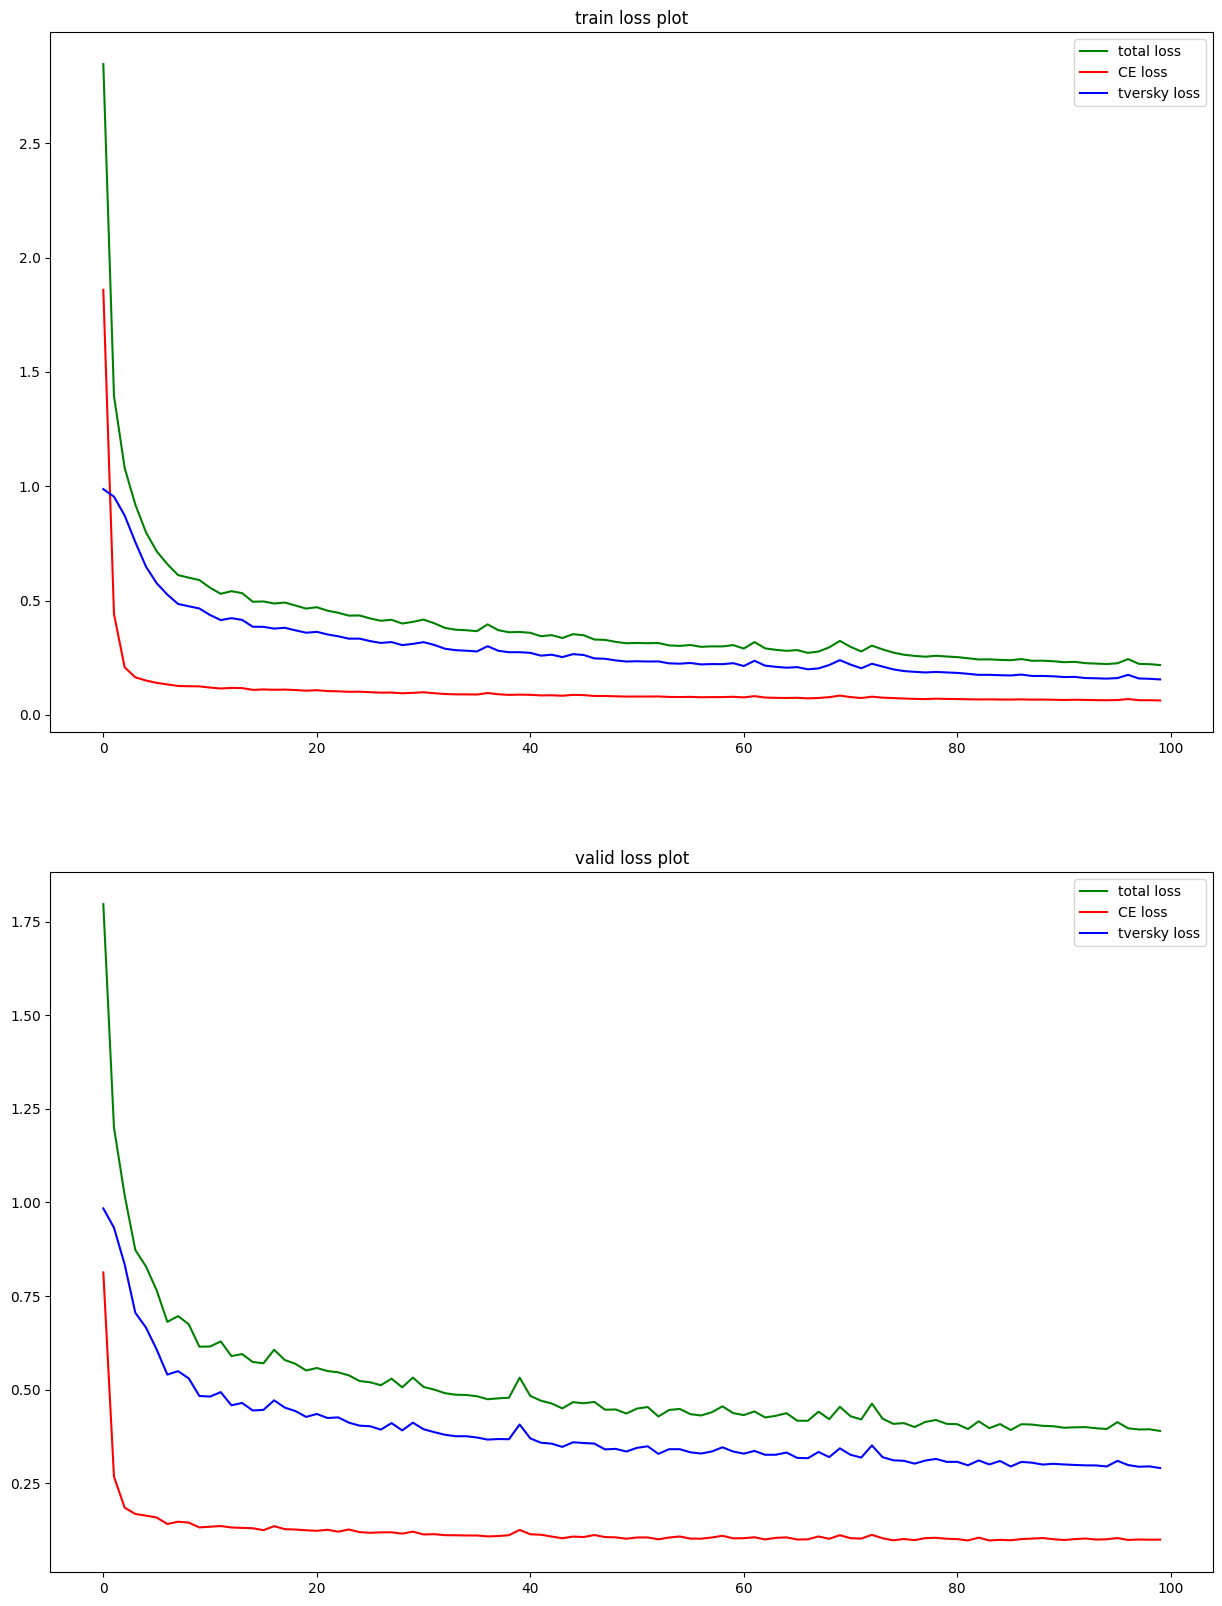

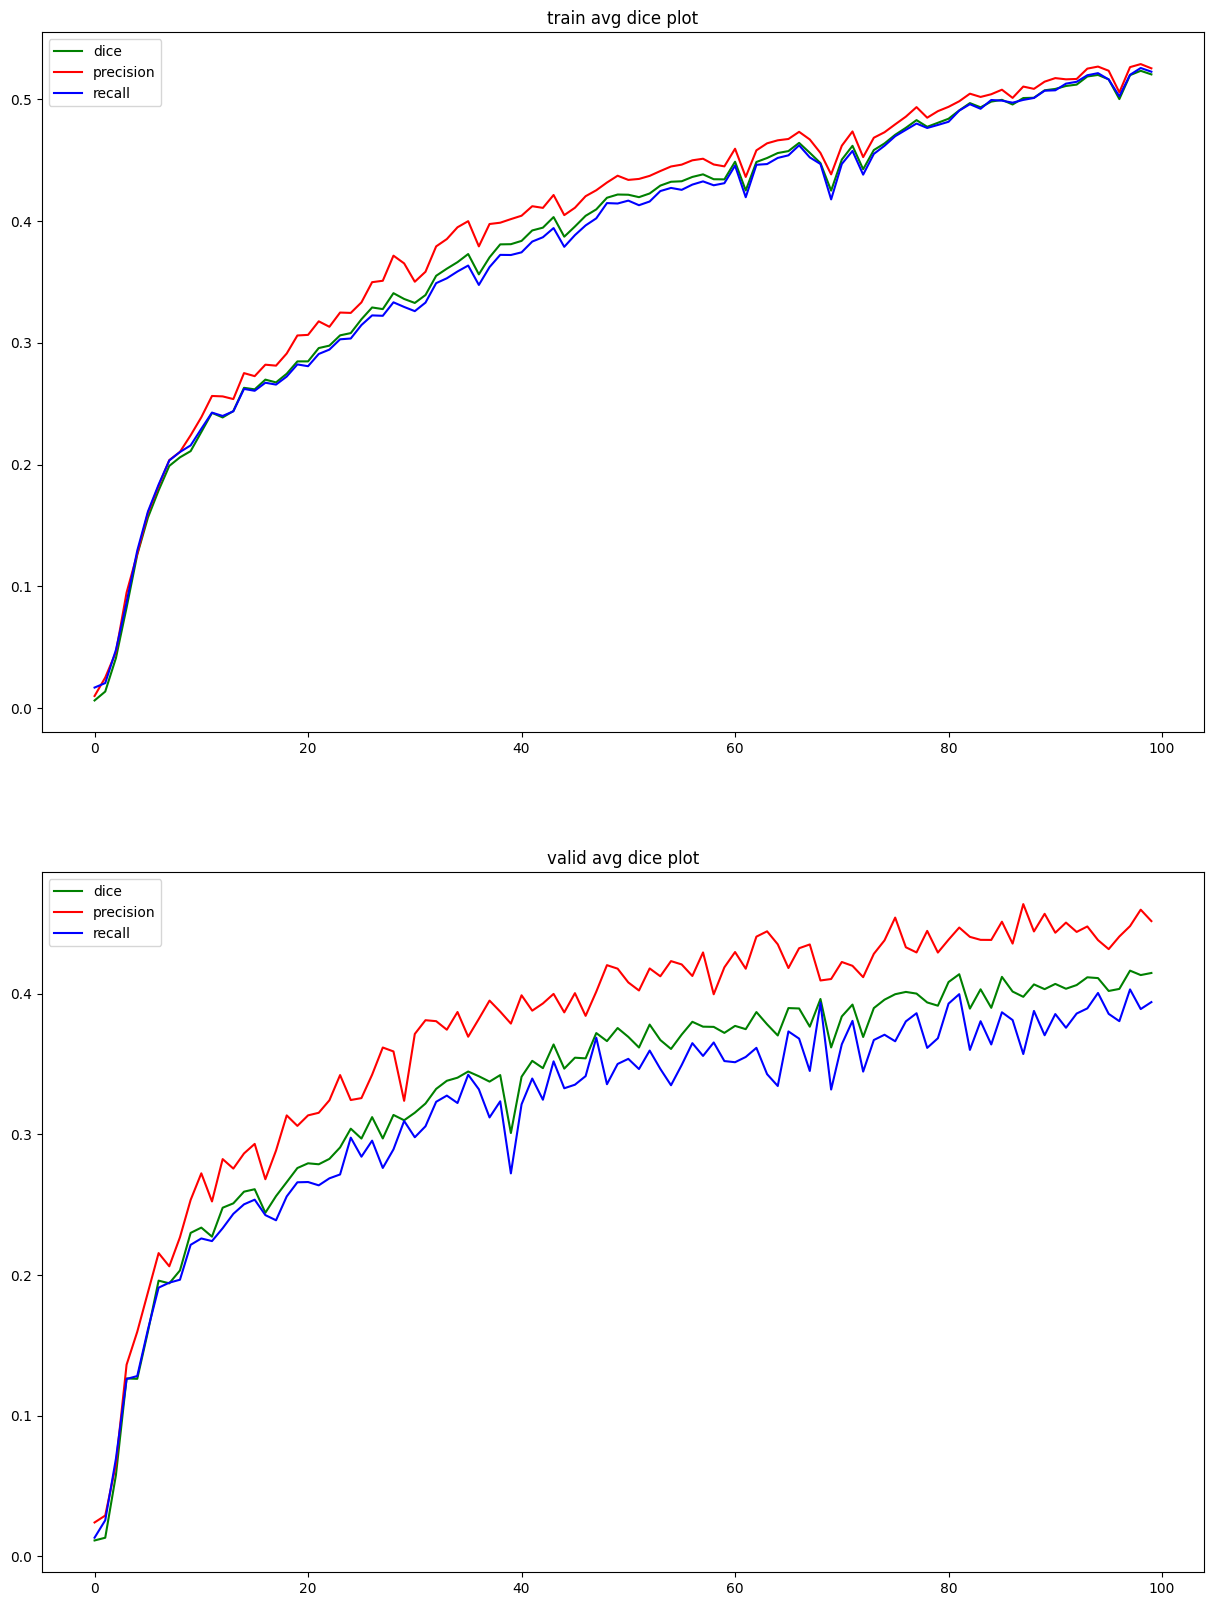

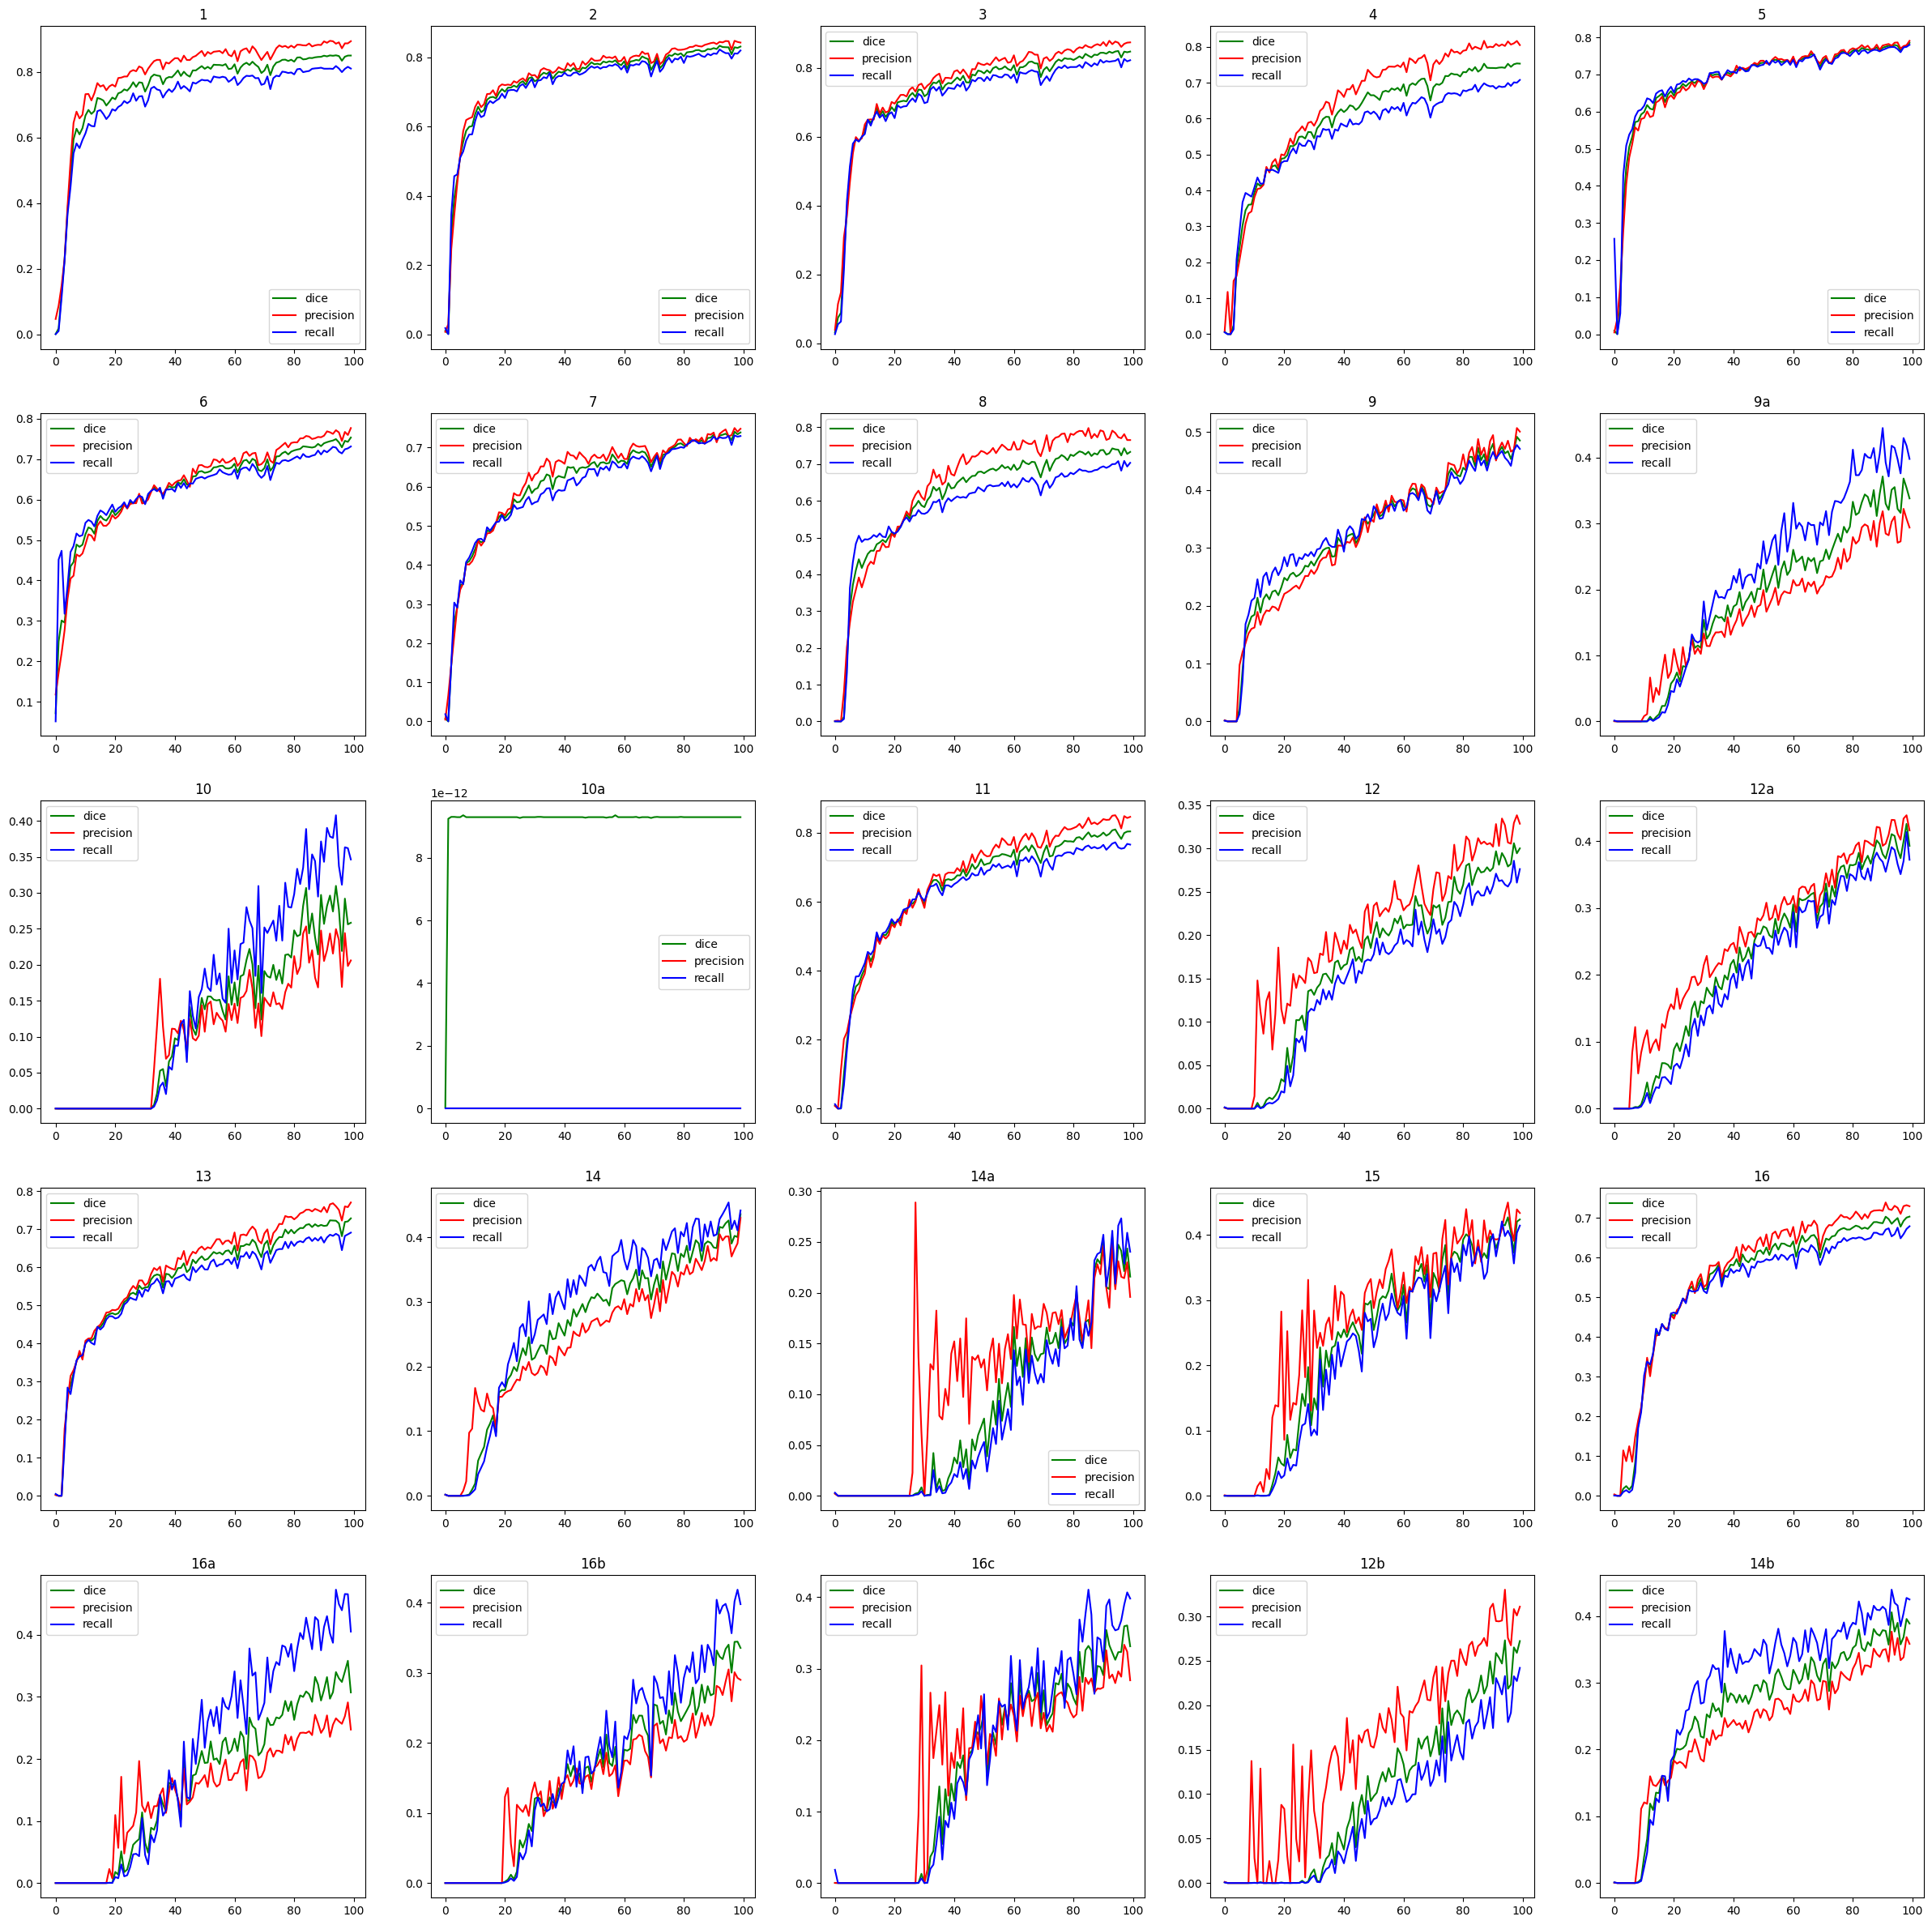

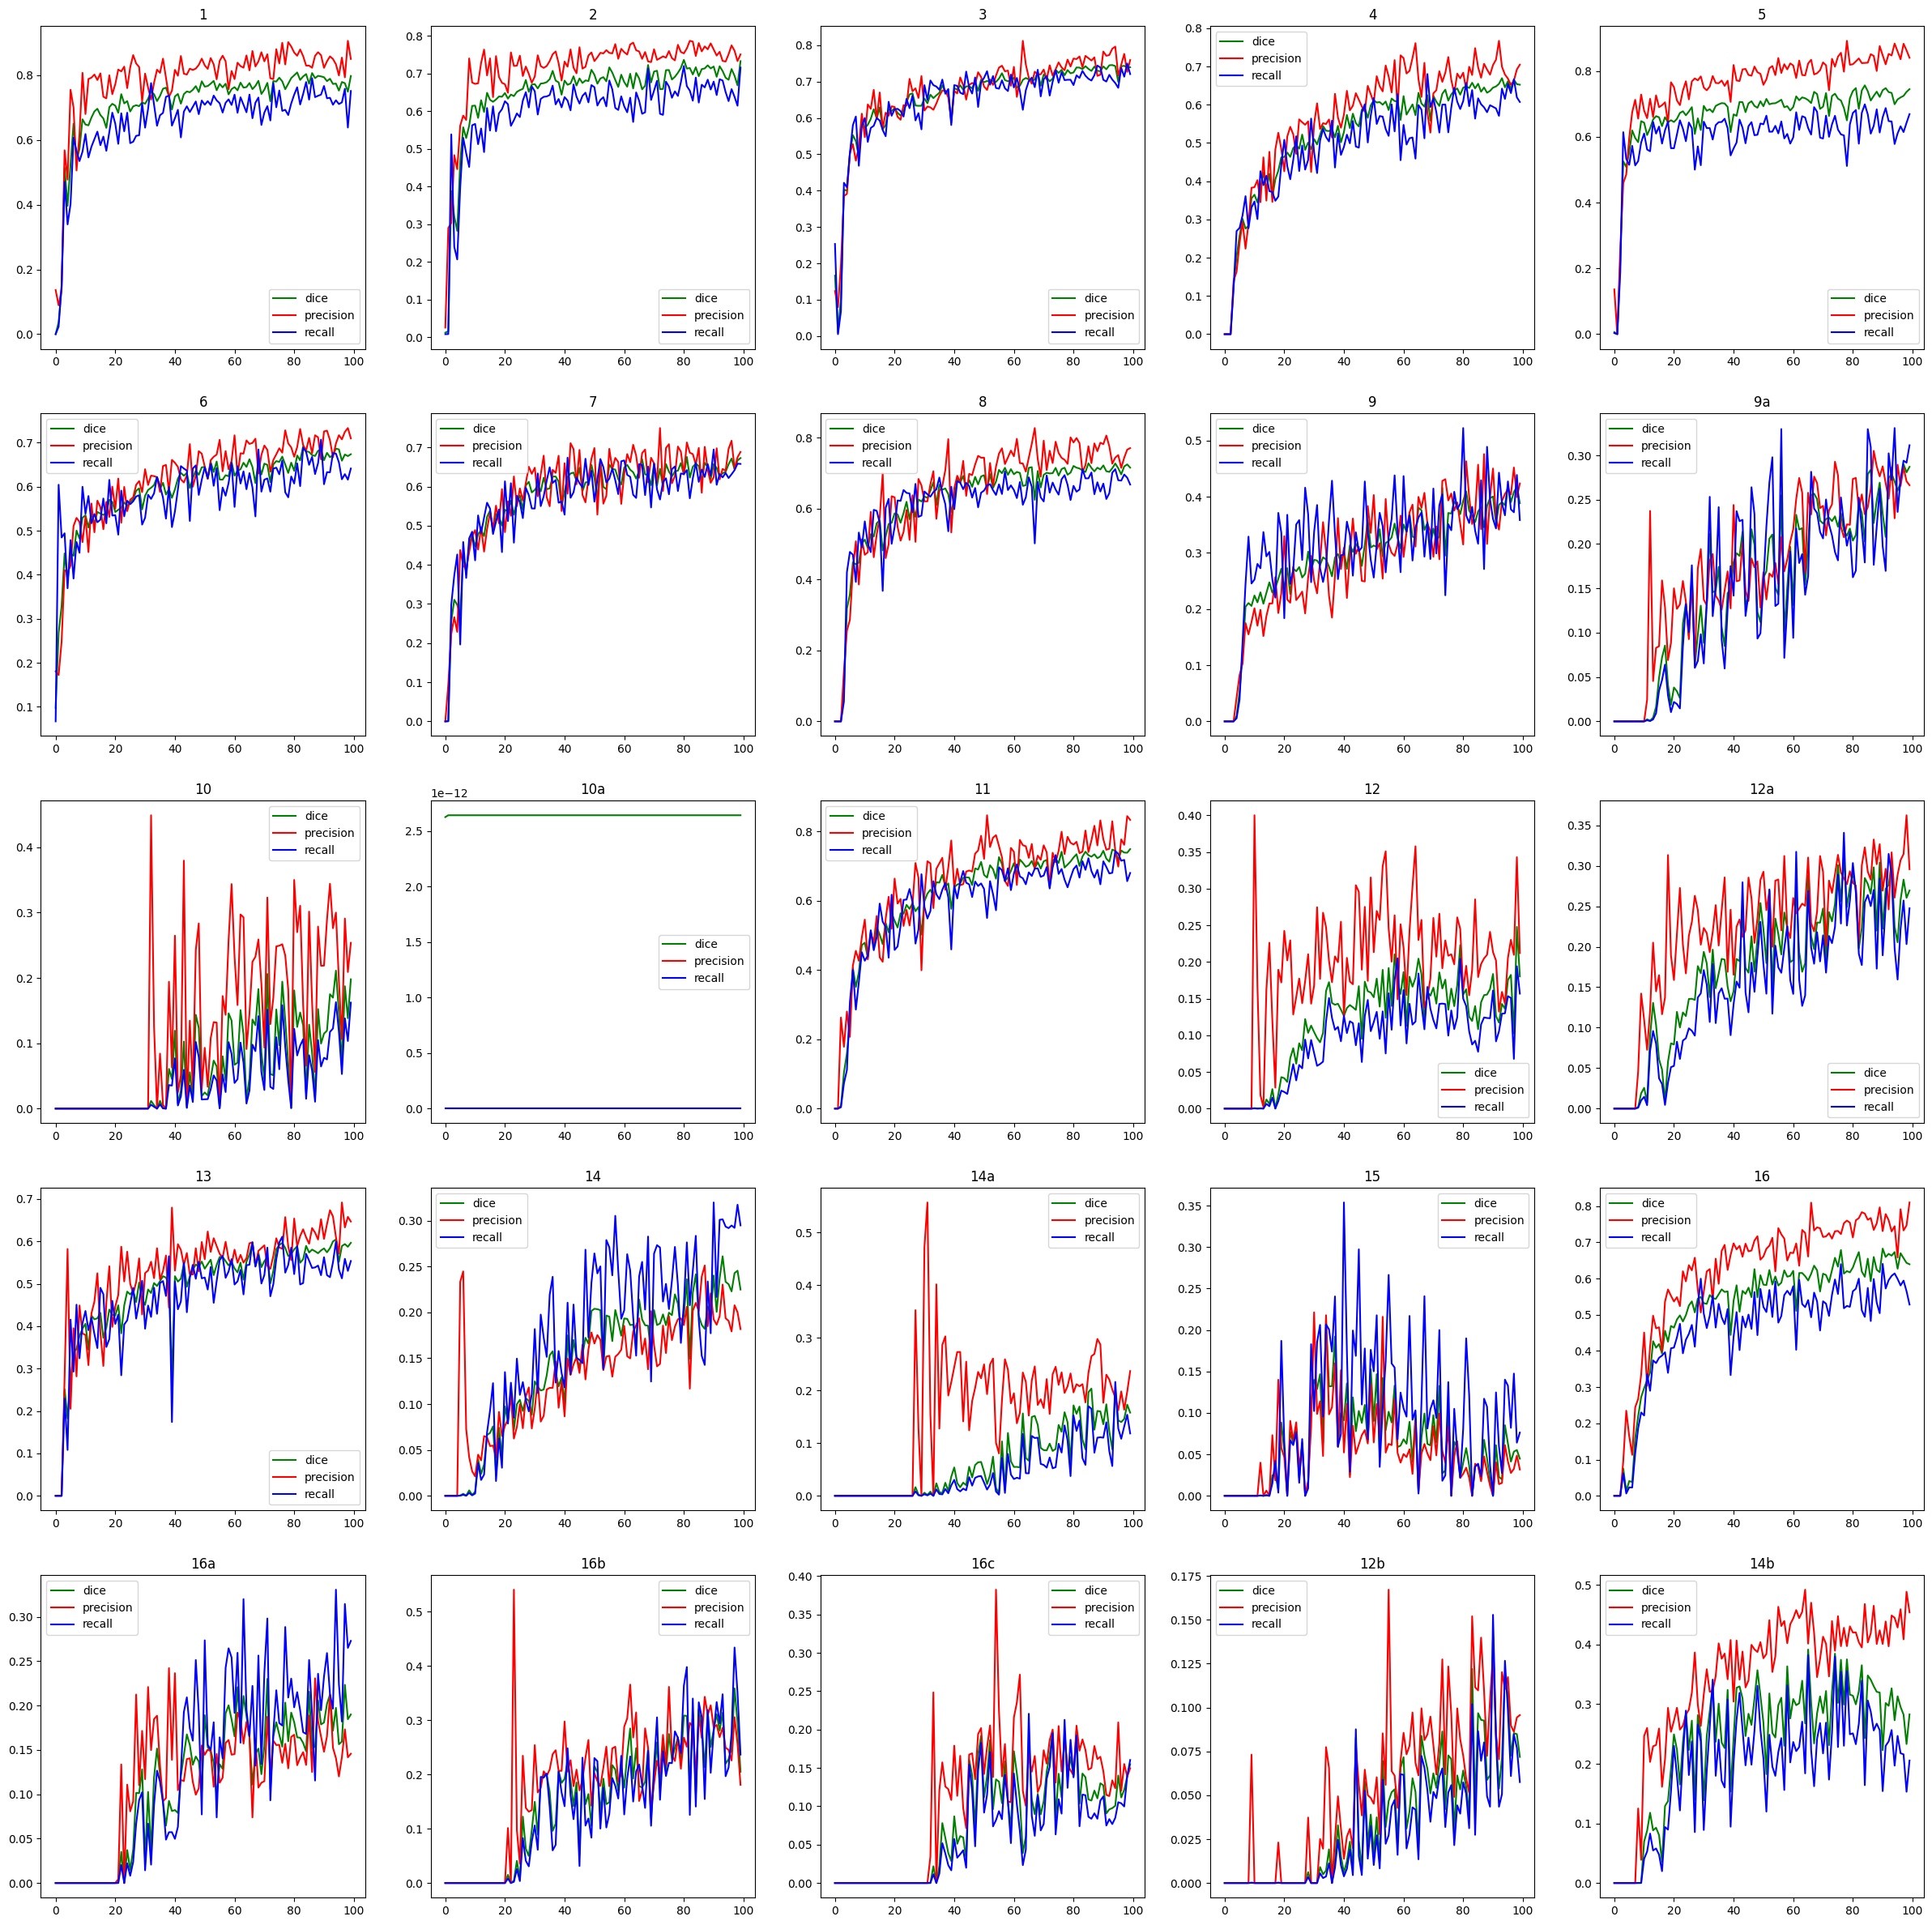

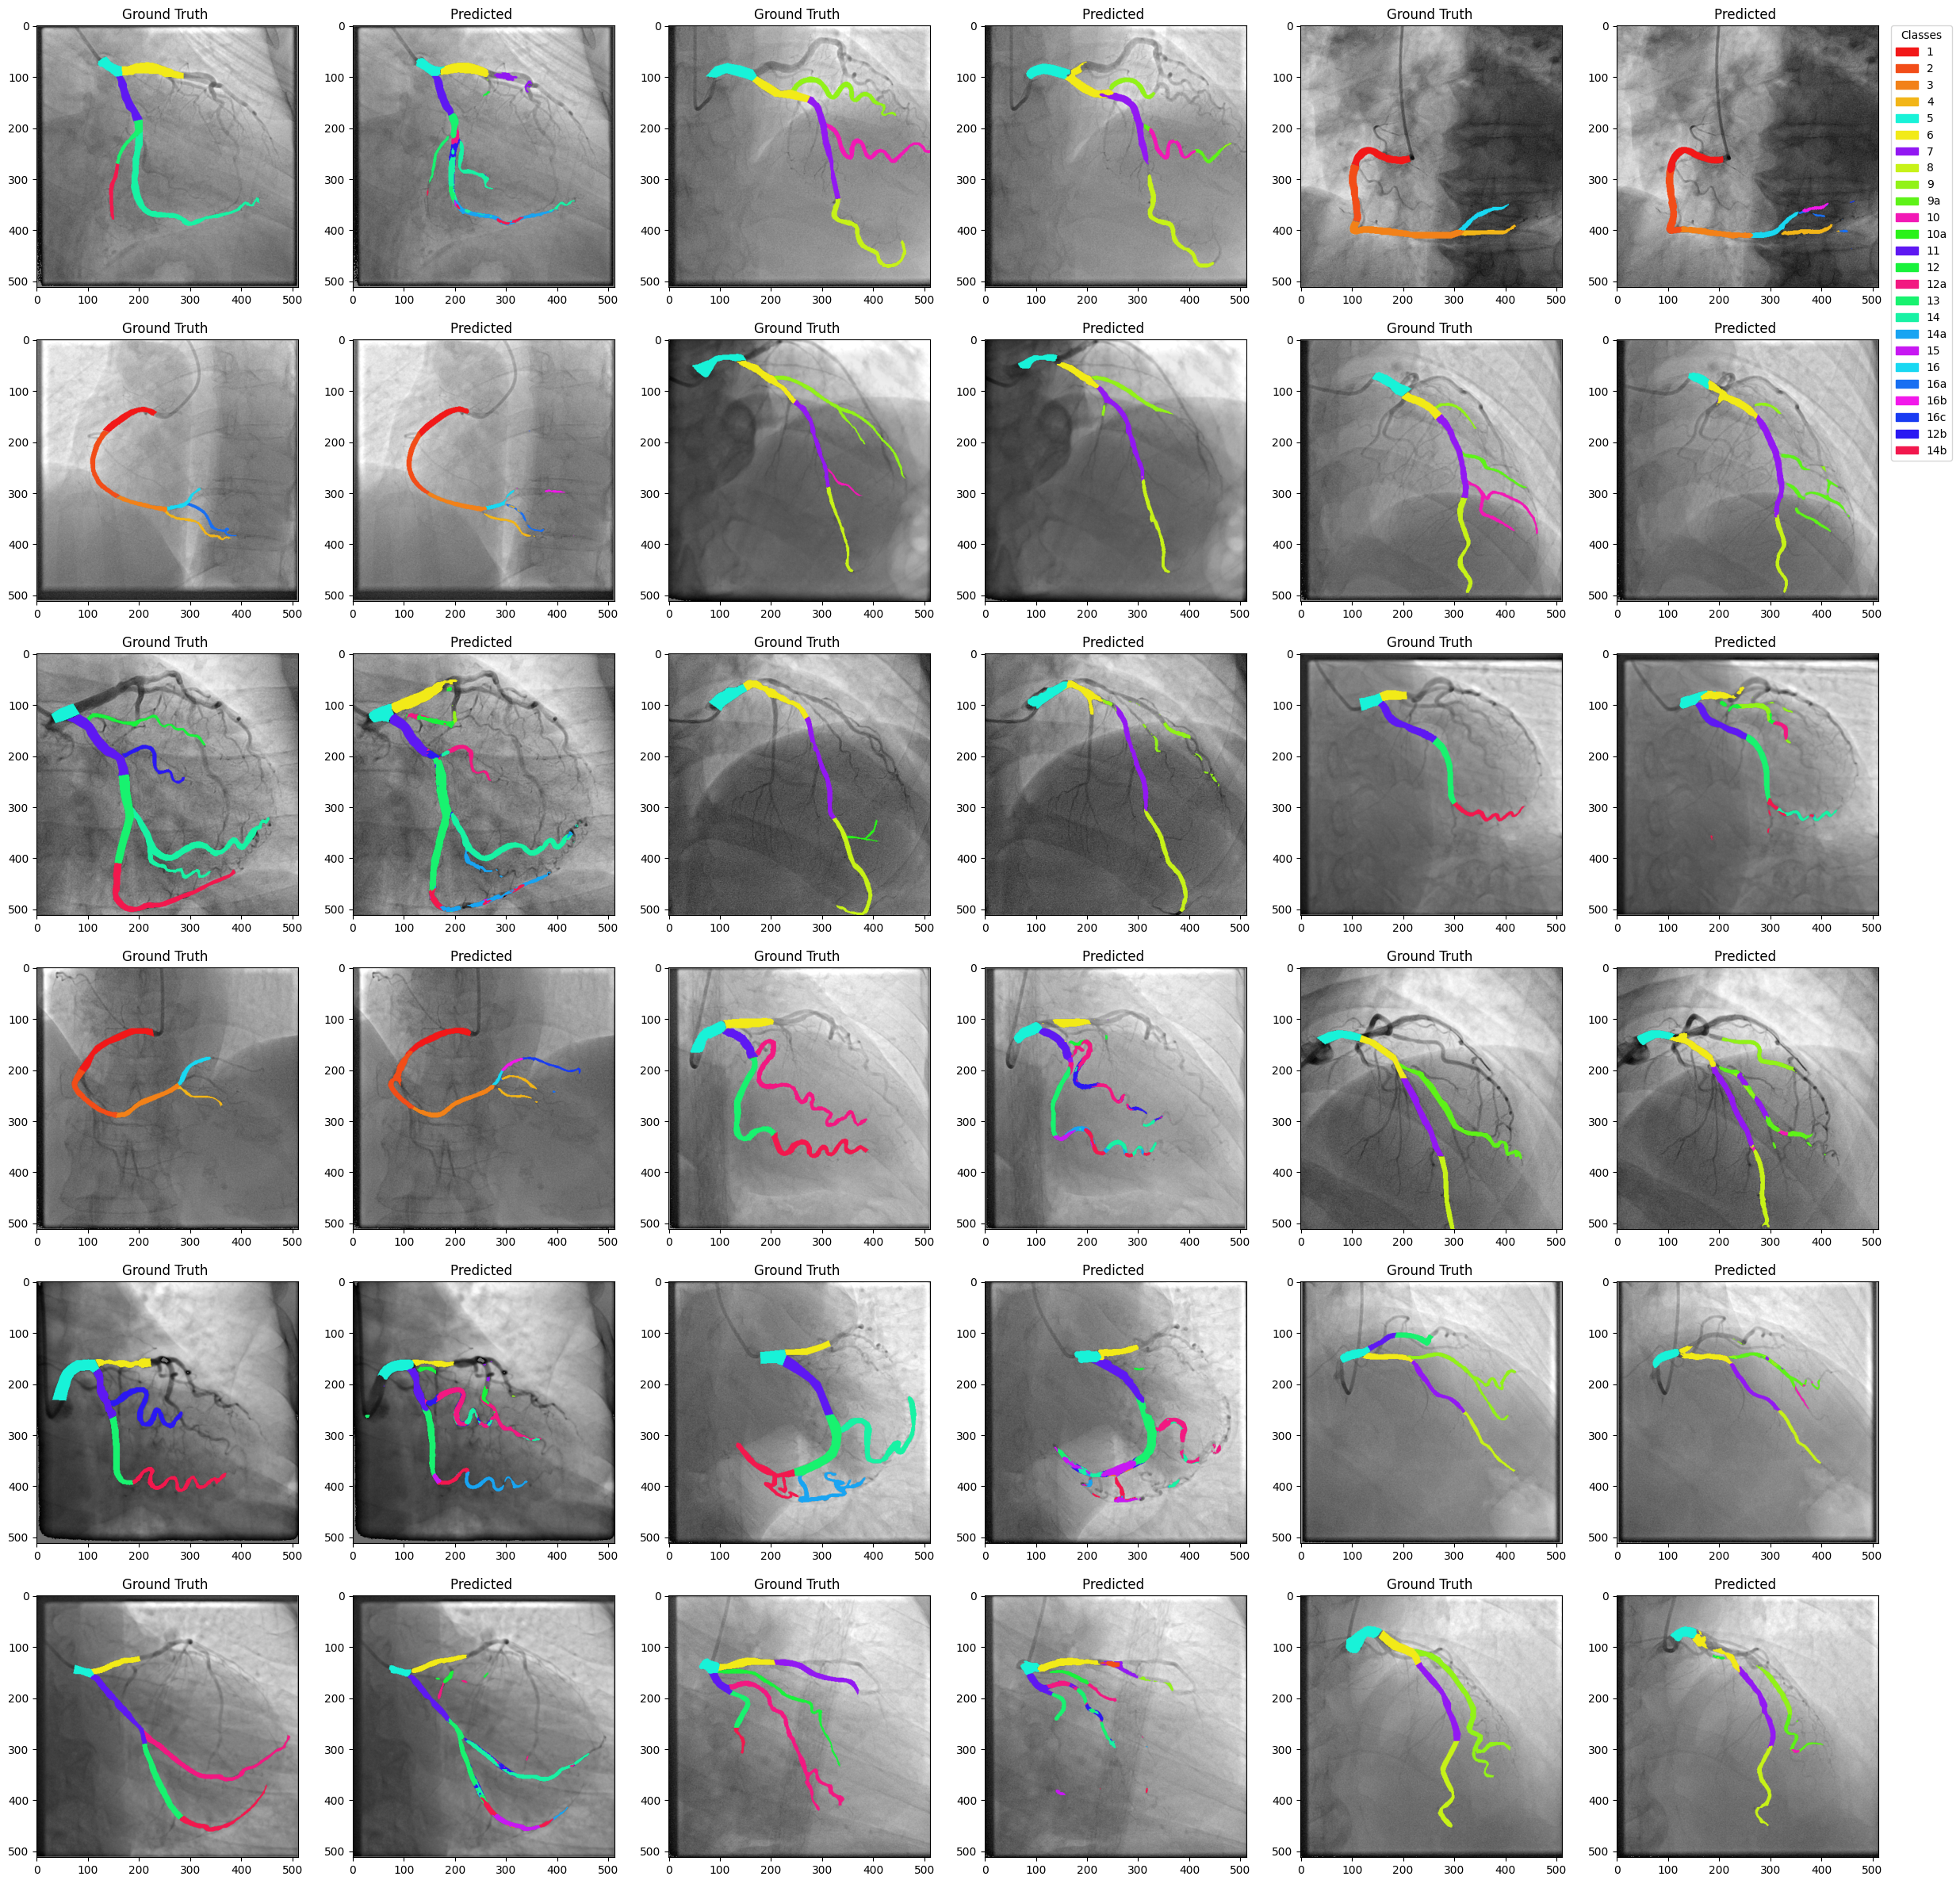

In [7]:
save_full_report(
    recorder= recorder , 
    output_base_path=args["output_base_path"],
    model=model,
    valid_loader=valid_loader,
    args=args,
    class_map=class_map,
    name=args["name"]
)